In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os
import seaborn as sns
from collections import Counter
import matplotlib
import platform



def set_chinese_font():
    system = platform.system()
    if system == 'Windows':
        matplotlib.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']
    elif system == 'Linux':
        # 优先使用Noto Sans CJK SC，其次WenQuanYi Micro Hei，再次SimHei
        matplotlib.rcParams['font.sans-serif'] = ['Noto Sans CJK SC', 'WenQuanYi Micro Hei', 'SimHei']
    else:
        # 其他系统可根据需要添加
        matplotlib.rcParams['font.sans-serif'] = ['SimHei']
    matplotlib.rcParams['axes.unicode_minus'] = False  # 正常显示负号

set_chinese_font()

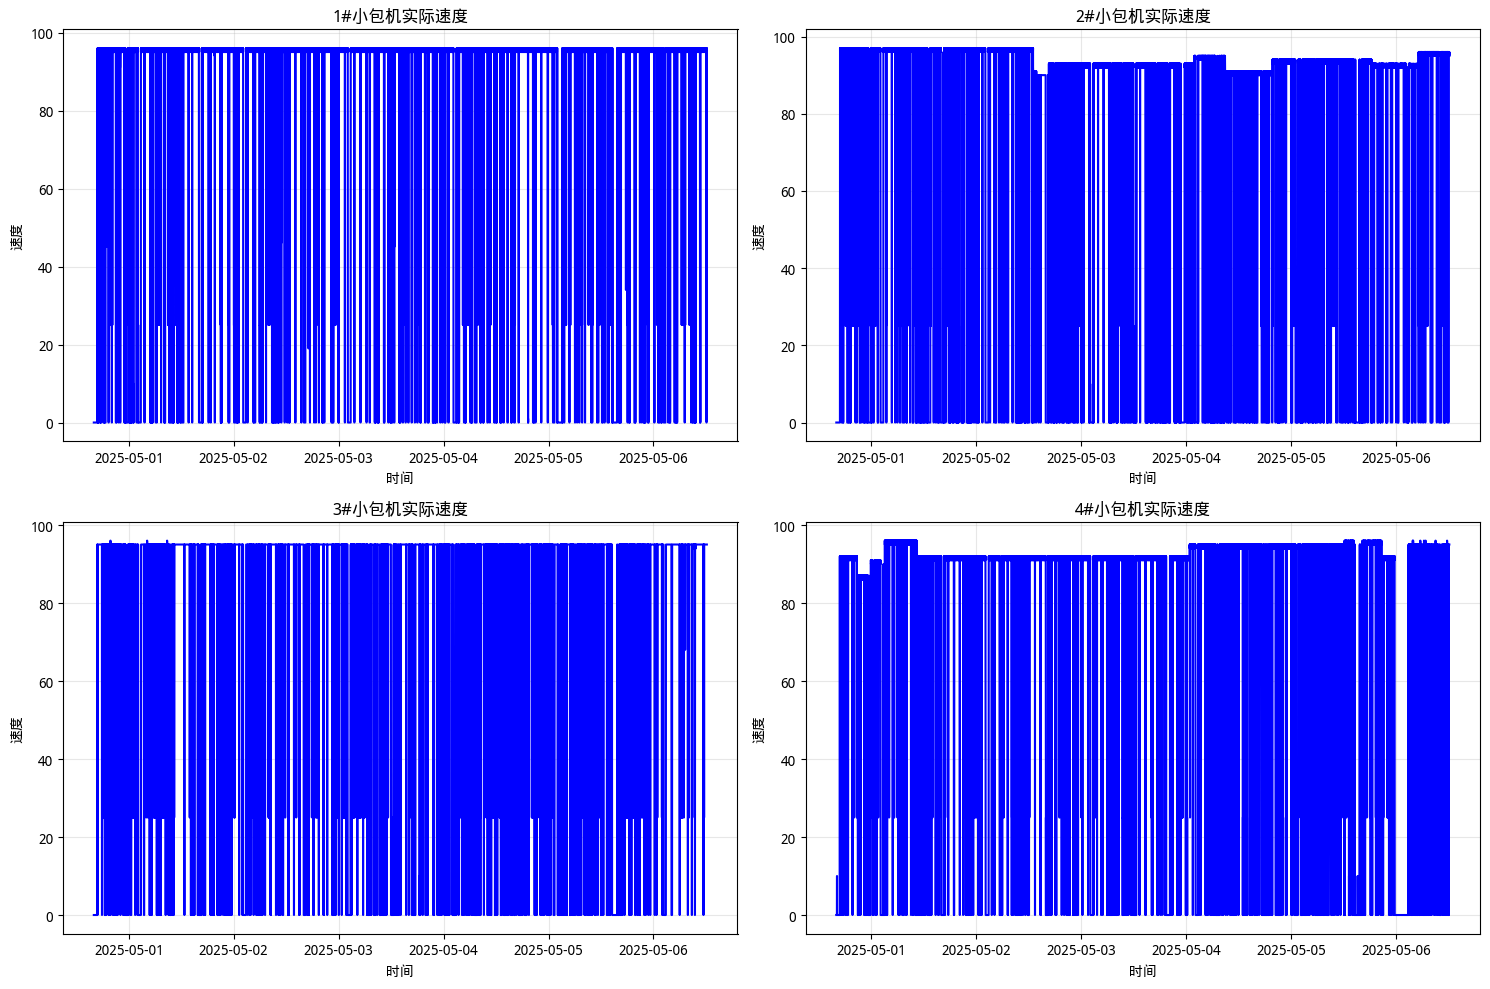

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 读取4台小包机的数据
data_files = [
    "1#小包机实际速度.csv",
    "2#小包机实际速度.csv", 
    "3#小包机实际速度.csv",
    "4#小包机实际速度.csv"
]

labels = ['1#小包机实际速度', '2#小包机实际速度', '3#小包机实际速度', '4#小包机实际速度']

# 创建2x2的子图布局
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()  # 将axes数组展平，便于索引

for i, (file_name, label) in enumerate(zip(data_files, labels)):
    try:
        # 读取数据
        data_path = Path("各点位") / file_name
        df = pd.read_csv(data_path)
        
        # 标准化列名
        if '时间' in df.columns:
            df = df.rename(columns={'时间': 'timestamp'})
        value_columns = [col for col in df.columns if col != 'timestamp']
        if value_columns:
            df = df.rename(columns={value_columns[0]: 'value'})
        
        # 转换时间格式
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.sort_values('timestamp')
        
        # 在对应的子图中绘制折线图
        axes[i].plot(df['timestamp'], df['value'], color='blue', linewidth=1.5)
        axes[i].set_xlabel('时间')
        axes[i].set_ylabel('速度')
        axes[i].set_title(label)
        axes[i].grid(True, alpha=0.3)
        
    except FileNotFoundError:
        print(f"警告: 找不到文件 {file_name}")
        axes[i].text(0.5, 0.5, f'文件 {file_name} 未找到', 
                    ha='center', va='center', transform=axes[i].transAxes)
    except Exception as e:
        print(f"处理文件 {file_name} 时出错: {e}")
        axes[i].text(0.5, 0.5, f'处理文件 {file_name} 时出错', 
                    ha='center', va='center', transform=axes[i].transAxes)

plt.tight_layout()
plt.show()



处理设备 XBJ1 (1#小包机)...
已生成 1029 个状态改变事件
事件数据已保存到: script/xbj1_events.json

XBJ1 前5个状态改变事件示例:
事件 1: 时间=2025-04-30 16:00:00, 速度=0.00, 状态变化: None -> 停机
事件 2: 时间=2025-04-30 16:50:43, 速度=95.00, 状态变化: 停机 -> 生产
事件 3: 时间=2025-04-30 16:52:07, 速度=25.00, 状态变化: 生产 -> 待机
事件 4: 时间=2025-04-30 16:52:17, 速度=0.00, 状态变化: 待机 -> 停机
事件 5: 时间=2025-04-30 16:54:37, 速度=95.00, 状态变化: 停机 -> 生产

处理设备 XBJ2 (2#小包机)...
已生成 1902 个状态改变事件
事件数据已保存到: script/xbj2_events.json

XBJ2 前5个状态改变事件示例:
事件 1: 时间=2025-04-30 16:00:00, 速度=0.00, 状态变化: None -> 停机
事件 2: 时间=2025-04-30 16:49:49, 速度=96.00, 状态变化: 停机 -> 生产
事件 3: 时间=2025-04-30 17:10:47, 速度=0.00, 状态变化: 生产 -> 停机
事件 4: 时间=2025-04-30 17:13:11, 速度=96.00, 状态变化: 停机 -> 生产
事件 5: 时间=2025-04-30 17:29:27, 速度=25.00, 状态变化: 生产 -> 待机

处理设备 XBJ3 (3#小包机)...
已生成 2082 个状态改变事件
事件数据已保存到: script/xbj3_events.json

XBJ3 前5个状态改变事件示例:
事件 1: 时间=2025-04-30 16:00:00, 速度=0.00, 状态变化: None -> 停机
事件 2: 时间=2025-04-30 16:46:38, 速度=95.00, 状态变化: 停机 -> 生产
事件 3: 时间=2025-04-30 16:47:03, 速度=25.00, 状态变化: 生产 -> 待机
事件 4: 时间

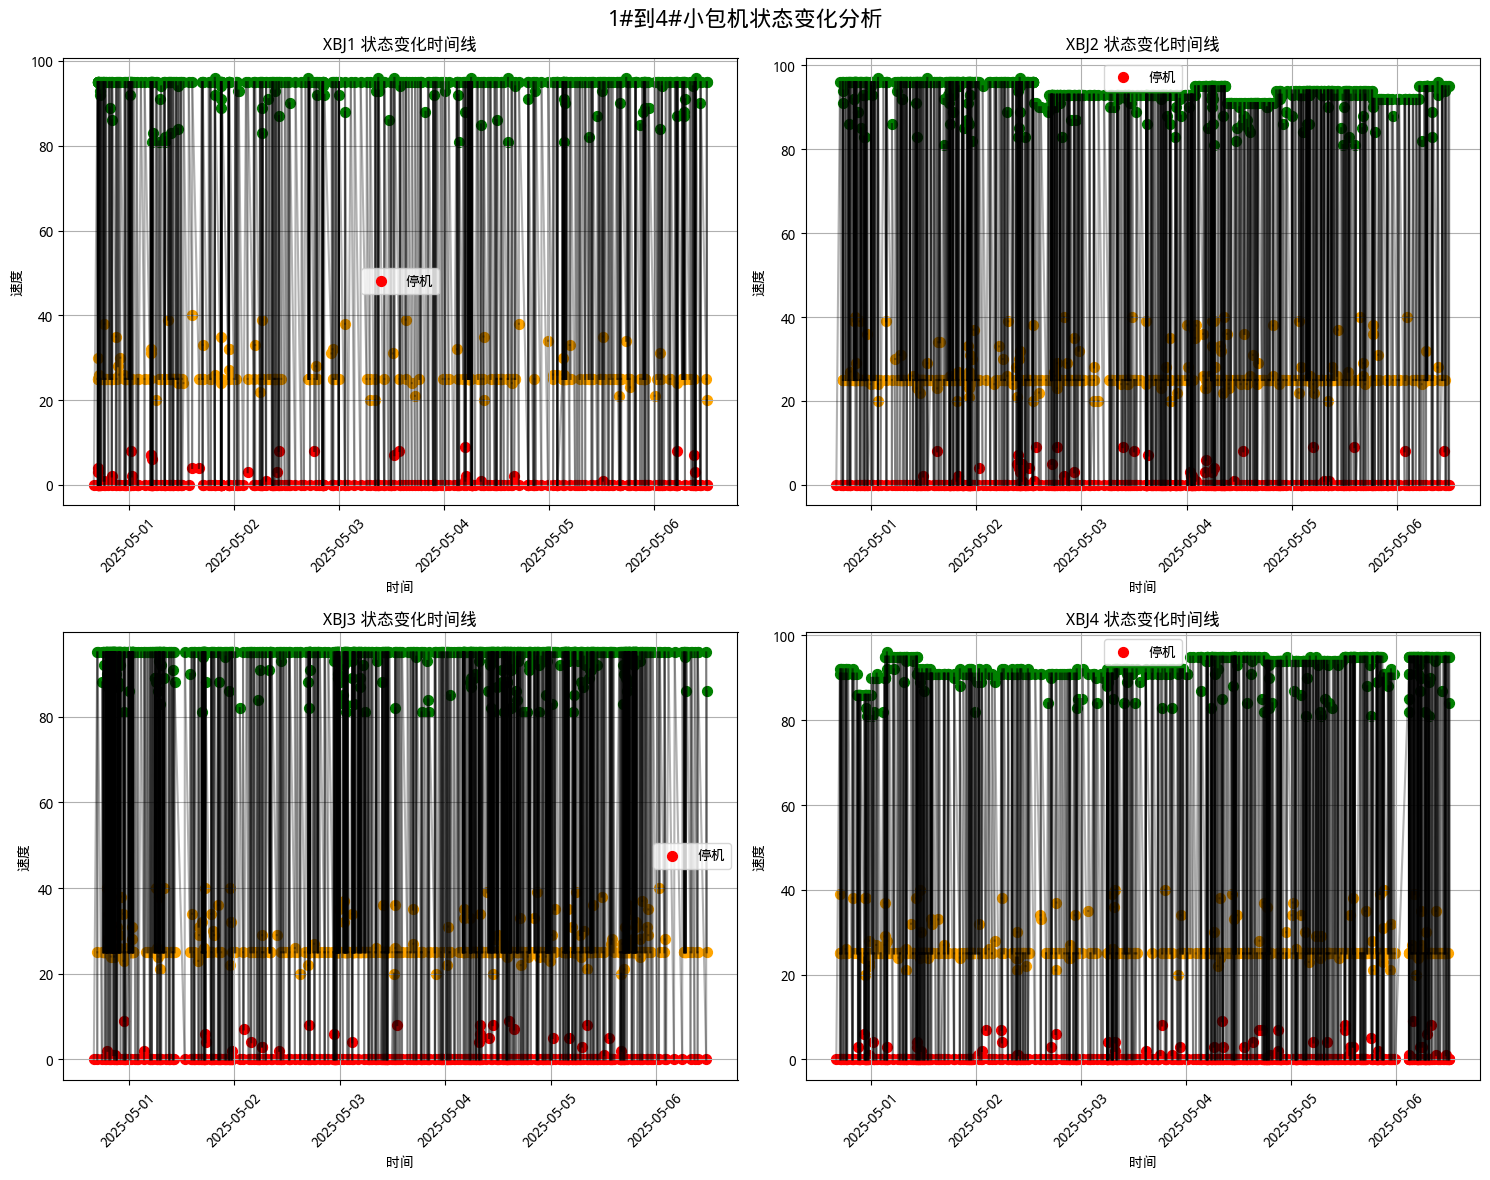

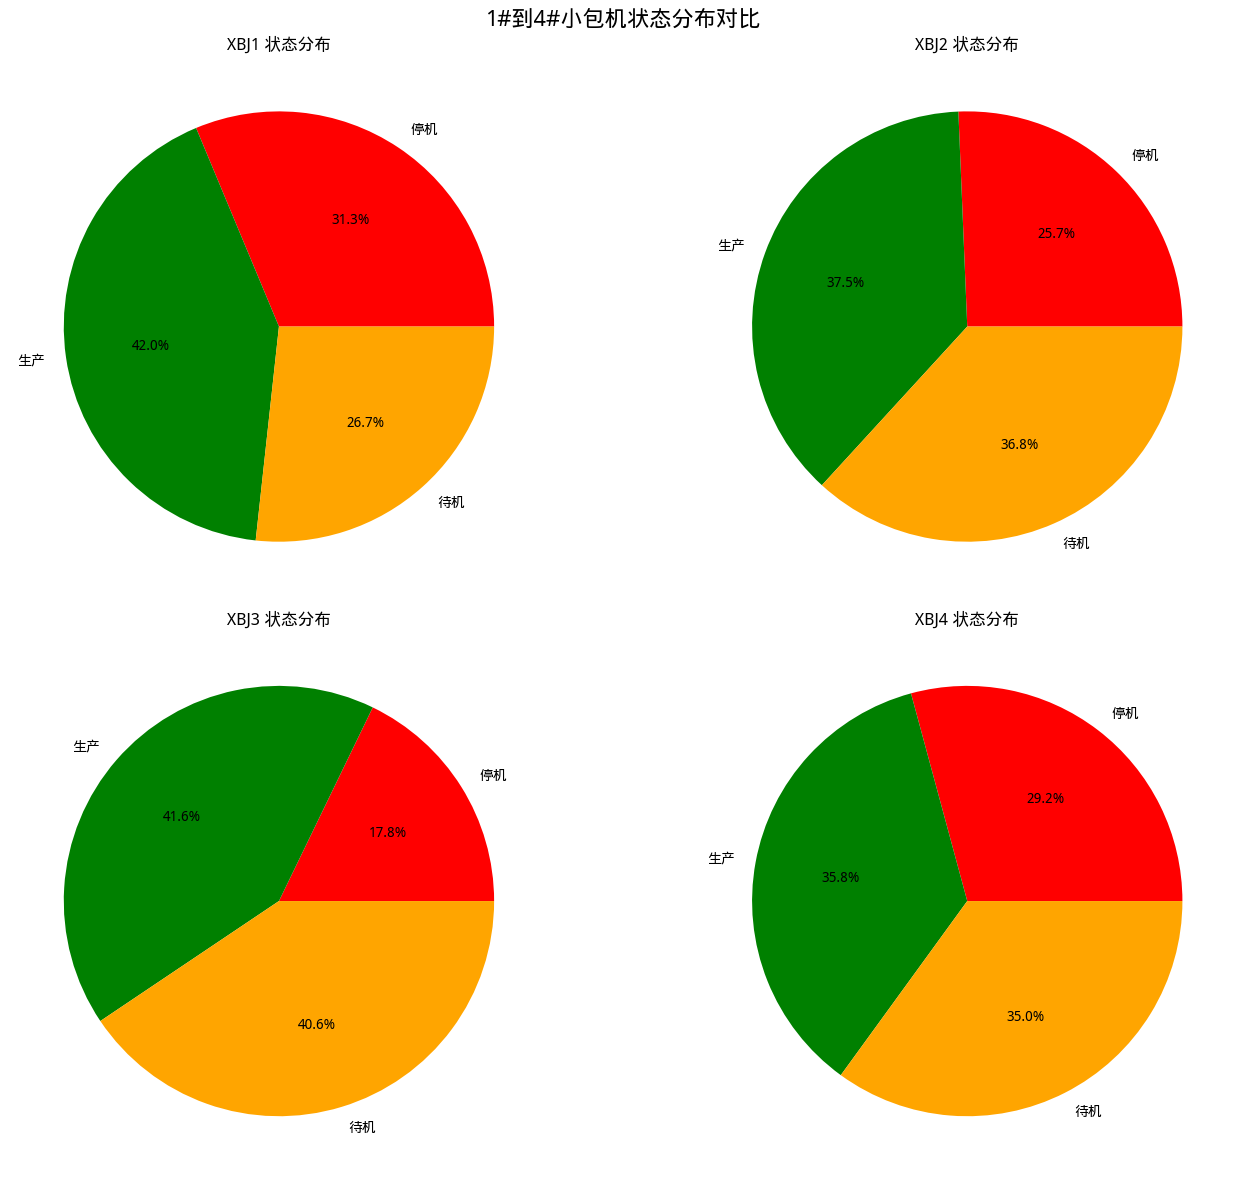


处理完成！共处理了 4 个设备的数据。


In [3]:
# 将1#到4#小包机实际速度数据转换为事件数据
import json
import os
from datetime import datetime, timedelta

def convert_speed_to_events(df, device_id):
    """
    将速度数据转换为事件数据，只记录状态改变
    
    Args:
        df: 包含timestamp和value列的DataFrame
        device_id: 设备ID
    """
    events = []
    
    # 确保数据按时间排序
    df = df.sort_values('timestamp').reset_index(drop=True)
    
    # 初始化状态
    current_status = None
    
    for idx, row in df.iterrows():
        speed_value = row['value']
        timestamp = row['timestamp']
        
        # 根据速度值确定设备状态
        if speed_value < 10:
            new_status = "停机"
        elif 20 <= speed_value <= 40:
            new_status = "待机"
        elif speed_value > 80:
            new_status = "生产"
        else:
            continue
        
        # 只有当状态发生改变时才记录事件
        if new_status != current_status:
            event = {
                "timestamp": timestamp.strftime("%Y-%m-%d %H:%M:%S"),
                "events": [
                    {
                        "event_type": "status_change",
                        "deviceID": device_id,
                        "params": {
                            "speed": float(speed_value),
                            "status": new_status,
                            "previous_status": current_status
                        }
                    }
                ]
            }
            events.append(event)
            current_status = new_status
    
    return events

def process_device_data(device_num, device_id):
    """
    处理单个设备的数据
    
    Args:
        device_num: 设备编号 (1-4)
        device_id: 设备ID (XBJ1-XBJ4)
    """
    # 读取设备数据
    data_path = f"各点位/{device_num}#小包机实际速度.csv"
    
    if not os.path.exists(data_path):
        print(f"警告: 文件 {data_path} 不存在，跳过设备 {device_id}")
        return None
    
    print(f"\n处理设备 {device_id} ({device_num}#小包机)...")
    
    # 读取数据
    device_df = pd.read_csv(data_path)
    
    # 标准化列名
    if '时间' in device_df.columns:
        device_df = device_df.rename(columns={'时间': 'timestamp'})
    
    value_columns = [col for col in device_df.columns if col != 'timestamp']
    if value_columns:
        device_df = device_df.rename(columns={value_columns[0]: 'value'})
    
    # 转换时间格式并处理数值
    device_df['timestamp'] = pd.to_datetime(device_df['timestamp'])
    device_df['value'] = pd.to_numeric(device_df['value'], errors='coerce')
    device_df = device_df.dropna().sort_values('timestamp')
    
    # 转换事件数据
    events_data = convert_speed_to_events(device_df, device_id)
    
    # 保存事件数据
    output_file = f"script/{device_id.lower()}_events.json"
    os.makedirs("script", exist_ok=True)
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(events_data, f, ensure_ascii=False, indent=2)
    
    print(f"已生成 {len(events_data)} 个状态改变事件")
    print(f"事件数据已保存到: {output_file}")
    
    # 显示前几个事件作为示例
    print(f"\n{device_id} 前5个状态改变事件示例:")
    for i, event in enumerate(events_data[:5]):
        speed = event['events'][0]['params']['speed']
        status = event['events'][0]['params']['status']
        prev_status = event['events'][0]['params']['previous_status']
        timestamp = event['timestamp']
        print(f"事件 {i+1}: 时间={timestamp}, 速度={speed:.2f}, 状态变化: {prev_status} -> {status}")
    
    return events_data, device_df

# 处理所有设备 (1#到4#小包机)
all_events = {}
all_data = {}

for device_num in range(1, 5):
    device_id = f"XBJ{device_num}"
    result = process_device_data(device_num, device_id)
    
    if result is not None:
        events_data, device_df = result
        all_events[device_id] = events_data
        all_data[device_id] = device_df

# 可视化所有设备的状态变化
if all_events:
    # 创建子图布局
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('1#到4#小包机状态变化分析', fontsize=16)
    
    colors = {'停机': 'red', '待机': 'orange', '生产': 'green', '运行': 'blue'}
    
    for idx, (device_id, events_data) in enumerate(all_events.items()):
        row = idx // 2
        col = idx % 2
        ax = axes[row, col]
        
        # 提取状态变化数据
        timestamps = [pd.to_datetime(event['timestamp']) for event in events_data]
        statuses = [event['events'][0]['params']['status'] for event in events_data]
        speeds = [event['events'][0]['params']['speed'] for event in events_data]
        
        # 绘制状态变化时间线
        for i, status in enumerate(statuses):
            ax.scatter(timestamps[i], speeds[i], c=colors[status], label=status if i == 0 else "", s=50)
            if i > 0:
                ax.plot([timestamps[i-1], timestamps[i]], [speeds[i-1], speeds[i]], 'k-', alpha=0.3)
        
        ax.set_xlabel('时间')
        ax.set_ylabel('速度')
        ax.set_title(f'{device_id} 状态变化时间线')
        ax.legend()
        ax.grid(True)
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # 创建状态分布对比图
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('1#到4#小包机状态分布对比', fontsize=16)
    
    for idx, (device_id, events_data) in enumerate(all_events.items()):
        row = idx // 2
        col = idx % 2
        ax = axes[row, col]
        
        # 统计状态分布
        statuses = [event['events'][0]['params']['status'] for event in events_data]
        status_counts = {}
        for status in statuses:
            status_counts[status] = status_counts.get(status, 0) + 1
        
        # 绘制饼图
        if status_counts:
            ax.pie(status_counts.values(), labels=status_counts.keys(), autopct='%1.1f%%', 
                   colors=[colors.get(status, 'gray') for status in status_counts.keys()])
            ax.set_title(f'{device_id} 状态分布')
    
    plt.tight_layout()
    plt.show()

print(f"\n处理完成！共处理了 {len(all_events)} 个设备的数据。")


            timestamp  value
0 2025-04-30 16:00:00    0.0
1 2025-04-30 16:00:01    0.0
2 2025-04-30 16:00:02    0.0
3 2025-04-30 16:00:03    0.0
4 2025-04-30 16:00:04    0.0


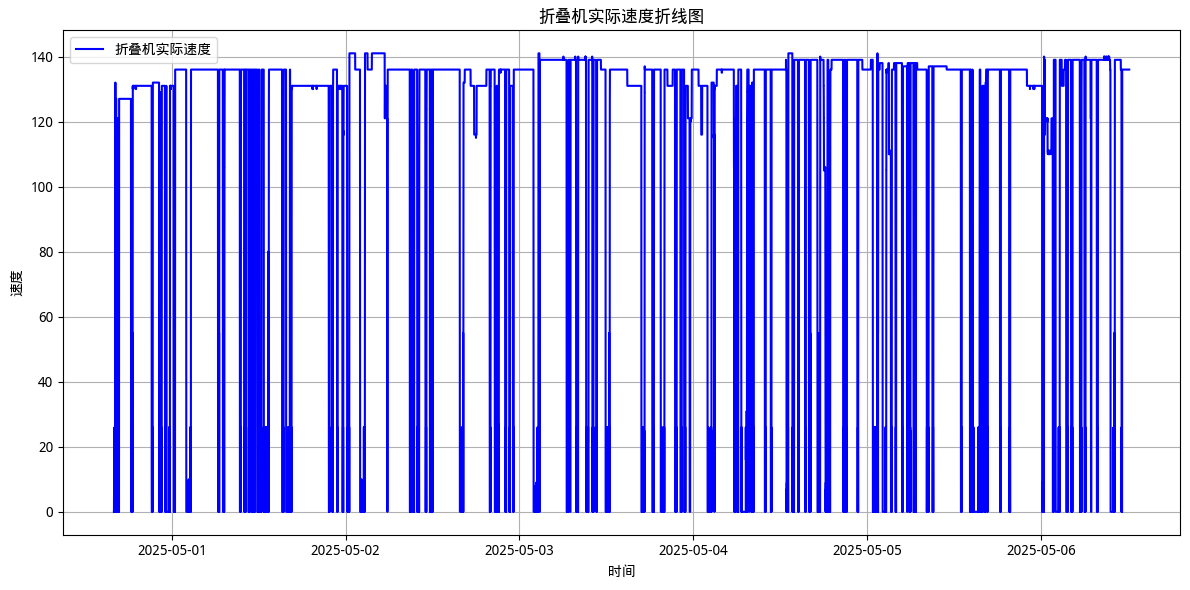

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 读取折叠机实际速度数据
data_path = Path("各点位") / "折叠机实际速度.csv"
df = pd.read_csv(data_path)

if '时间' in df.columns:
    df = df.rename(columns={'时间': 'timestamp'})
value_columns = [col for col in df.columns if col != 'timestamp']
if value_columns:
    df = df.rename(columns={value_columns[0]: 'value'})

# 转换时间格式
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

print(df.head())

# 绘制折线图
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['value'], label='折叠机实际速度', color='blue')
plt.xlabel('时间')
plt.ylabel('速度')
plt.title('折叠机实际速度折线图')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()







=== 折叠机速度数据分析 ===
数据点数量: 494149
速度范围: 0.00 - 141.00
平均速度: 110.08
速度标准差: 51.33

=== 聚类分析结果 ===
聚类 0: 中心速度 = 135.03, 数据点数量 = 397474
聚类 1: 中心速度 = 3.46, 数据点数量 = 89672
聚类 2: 中心速度 = 58.94, 数据点数量 = 7003

=== 状态分布统计 ===
生产: 397474 个数据点 (80.4%)
停机: 89672 个数据点 (18.1%)
待机: 7003 个数据点 (1.4%)


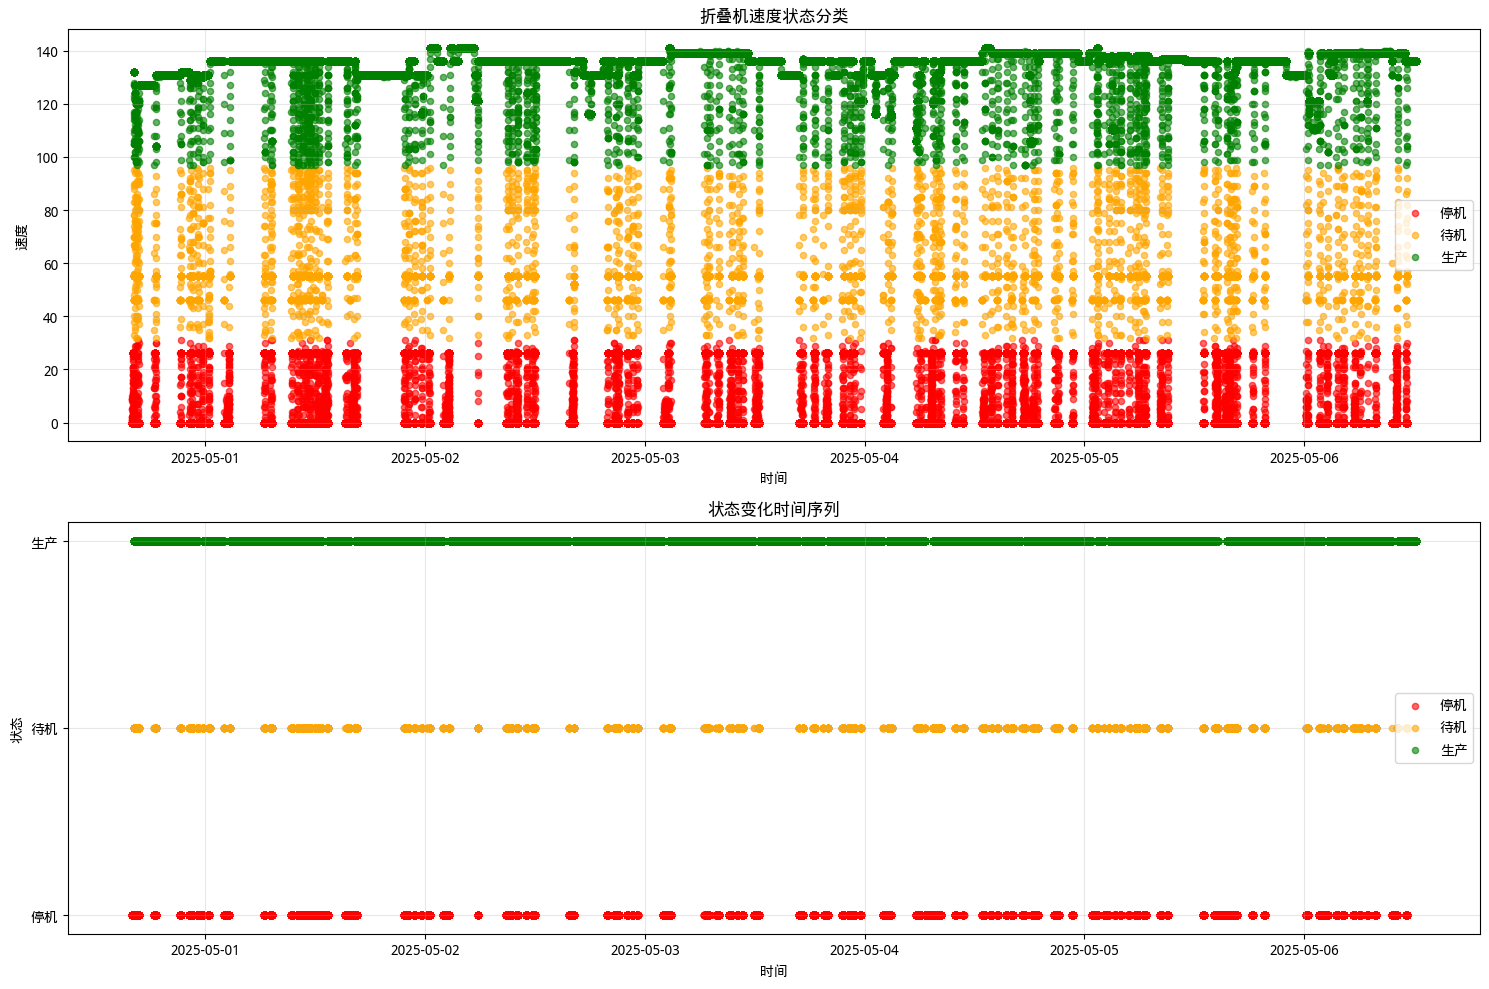


分类结果已保存到: 各点位/折叠机速度状态分类.csv

=== 状态转换分析 ===
检测到 508 次状态转换:
  2025-04-30 16:10:19: 停机 → 待机
  2025-04-30 16:10:59: 待机 → 生产
  2025-04-30 16:12:10: 生产 → 待机
  2025-04-30 16:12:25: 待机 → 停机
  2025-04-30 16:16:10: 停机 → 待机
  2025-04-30 16:16:51: 待机 → 生产
  2025-04-30 16:19:21: 生产 → 待机
  2025-04-30 16:19:39: 待机 → 停机
  2025-04-30 16:25:25: 停机 → 待机
  2025-04-30 16:26:15: 待机 → 生产
  ... 还有 498 次转换


In [5]:
# 分析折叠机实际速度的趋势并分类状态
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 分析速度数据的统计特征
print("=== 折叠机速度数据分析 ===")
print(f"数据点数量: {len(df)}")
print(f"速度范围: {df['value'].min():.2f} - {df['value'].max():.2f}")
print(f"平均速度: {df['value'].mean():.2f}")
print(f"速度标准差: {df['value'].std():.2f}")

# 使用K-means聚类将速度分为3个状态
scaler = StandardScaler()
speed_scaled = scaler.fit_transform(df[['value']].values)

kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(speed_scaled)

# 分析聚类结果
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers = cluster_centers.flatten()

print("\n=== 聚类分析结果 ===")
for i, center in enumerate(cluster_centers):
    cluster_data = df[df['cluster'] == i]['value']
    print(f"聚类 {i}: 中心速度 = {center:.2f}, 数据点数量 = {len(cluster_data)}")

# 根据速度值确定状态标签
# 假设：速度接近0为停机，中等速度为待机，高速度为生产
sorted_centers = np.argsort(cluster_centers)
state_mapping = {
    sorted_centers[0]: '停机',
    sorted_centers[1]: '待机', 
    sorted_centers[2]: '生产'
}

df['status'] = df['cluster'].map(state_mapping)

# 统计各状态的时间分布
print("\n=== 状态分布统计 ===")
status_counts = df['status'].value_counts()
for status, count in status_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{status}: {count} 个数据点 ({percentage:.1f}%)")

# 可视化状态分类结果
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# 上图：原始速度数据和聚类中心
colors = {'停机': 'red', '待机': 'orange', '生产': 'green'}
for status in ['停机', '待机', '生产']:
    status_data = df[df['status'] == status]
    ax1.scatter(status_data['timestamp'], status_data['value'], 
                c=colors[status], label=status, alpha=0.6, s=20)

ax1.set_xlabel('时间')
ax1.set_ylabel('速度')
ax1.set_title('折叠机速度状态分类')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 下图：状态时间序列
for status in ['停机', '待机', '生产']:
    status_data = df[df['status'] == status]
    ax2.scatter(status_data['timestamp'], [status] * len(status_data), 
                c=colors[status], label=status, alpha=0.6, s=20)

ax2.set_xlabel('时间')
ax2.set_ylabel('状态')
ax2.set_title('状态变化时间序列')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 保存分类结果
output_df = df[['timestamp', 'value', 'status']].copy()
output_path = Path("各点位") / "折叠机速度状态分类.csv"
output_df.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"\n分类结果已保存到: {output_path}")

# 分析状态转换
print("\n=== 状态转换分析 ===")
df_sorted = df.sort_values('timestamp')
status_changes = []
for i in range(1, len(df_sorted)):
    current_status = df_sorted.iloc[i]['status']
    previous_status = df_sorted.iloc[i-1]['status']
    if current_status != previous_status:
        status_changes.append({
            'timestamp': df_sorted.iloc[i]['timestamp'],
            'from': previous_status,
            'to': current_status
        })

if status_changes:
    print(f"检测到 {len(status_changes)} 次状态转换:")
    for change in status_changes[:10]:  # 显示前10次转换
        print(f"  {change['timestamp']}: {change['from']} → {change['to']}")
    if len(status_changes) > 10:
        print(f"  ... 还有 {len(status_changes) - 10} 次转换")
else:
    print("未检测到状态转换")


In [6]:
# 将折叠机速度的事件数据保存到script文件夹下
import json
from pathlib import Path
from datetime import datetime

# 创建script文件夹（如果不存在）
script_dir = Path("script")
script_dir.mkdir(exist_ok=True)

# 从分类结果中提取事件数据
events_data = []
df_sorted = df.sort_values('timestamp')

for i, row in df_sorted.iterrows():
    # 确定事件类型
    if i == 0:
        # 第一条记录，状态从null变为当前状态
        event_type = "status_change"
        previous_status = None
    else:
        previous_row = df_sorted.iloc[i-1]
        if row['status'] != previous_row['status']:
            event_type = "status_change"
            previous_status = previous_row['status']
        else:
            # 状态未变化，跳过
            continue
    
    # 构建事件数据
    event = {
        "timestamp": row['timestamp'].strftime("%Y-%m-%d %H:%M:%S"),
        "events": [
            {
                "event_type": event_type,
                "deviceID": "折叠机",  # 可以根据实际情况修改设备ID
                "params": {
                    "speed": float(row['value']),
                    "status": row['status'],
                    "previous_status": previous_status
                }
            }
        ]
    }
    events_data.append(event)

# 保存到JSON文件
output_file = script_dir / "折叠机_events.json"
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(events_data, f, ensure_ascii=False, indent=2)

print(f"事件数据已保存到: {output_file}")
print(f"共保存了 {len(events_data)} 个事件记录")

# 显示前几个事件作为示例
print("\n前3个事件示例:")
for i, event in enumerate(events_data[:3]):
    print(f"事件 {i+1}:")
    print(f"  时间: {event['timestamp']}")
    print(f"  事件类型: {event['events'][0]['event_type']}")
    print(f"  设备ID: {event['events'][0]['deviceID']}")
    print(f"  速度: {event['events'][0]['params']['speed']}")
    print(f"  状态: {event['events'][0]['params']['status']}")
    print(f"  前一状态: {event['events'][0]['params']['previous_status']}")
    print()


事件数据已保存到: script/折叠机_events.json
共保存了 509 个事件记录

前3个事件示例:
事件 1:
  时间: 2025-04-30 16:00:00
  事件类型: status_change
  设备ID: 折叠机
  速度: 0.0
  状态: 停机
  前一状态: None

事件 2:
  时间: 2025-04-30 16:10:19
  事件类型: status_change
  设备ID: 折叠机
  速度: 33.0
  状态: 待机
  前一状态: 停机

事件 3:
  时间: 2025-04-30 16:10:59
  事件类型: status_change
  设备ID: 折叠机
  速度: 100.0
  状态: 生产
  前一状态: 待机



存纸率数据读取成功
数据形状: (494149, 2)

数据前5行:
                    时间  存纸率
0  2025-04-30 16:00:00  0.0
1  2025-04-30 16:00:01  0.0
2  2025-04-30 16:00:02  0.0
3  2025-04-30 16:00:03  0.0
4  2025-04-30 16:00:04  0.0

数据基本信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494149 entries, 0 to 494148
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   时间      494149 non-null  object 
 1   存纸率     494149 non-null  float64
dtypes: float64(1), object(1)
memory usage: 7.5+ MB
None
             timestamp  paper_storage_rate
0  2025-04-30 16:00:00                 0.0
1  2025-04-30 16:00:01                 0.0
2  2025-04-30 16:00:02                 0.0
3  2025-04-30 16:00:03                 0.0
4  2025-04-30 16:00:04                 0.0


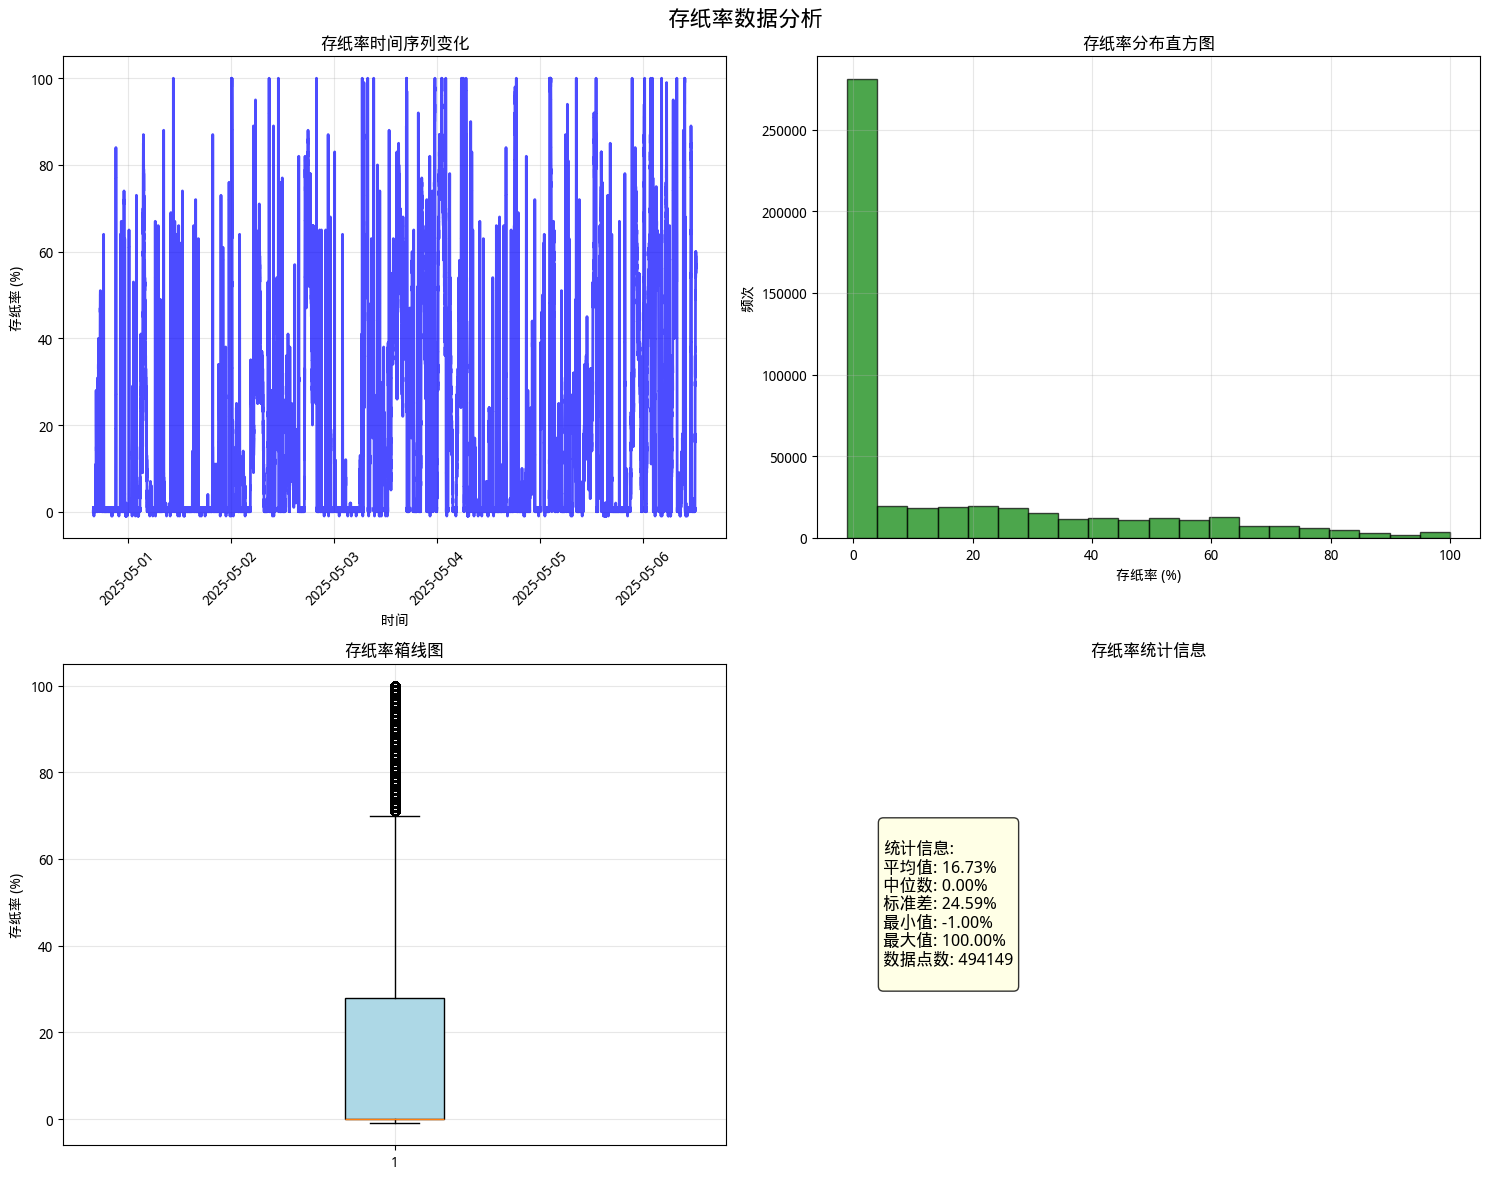


=== 存纸率趋势分析 ===
存纸率变化范围: 101.00%
存纸率变化率: inf%

发现 25041 个异常值:
                 timestamp  paper_storage_rate
18514  2025-04-30 21:15:28                71.0
18515  2025-04-30 21:15:29                71.0
18516  2025-04-30 21:15:30                71.0
18517  2025-04-30 21:15:31                72.0
18518  2025-04-30 21:15:32                72.0
...                    ...                 ...
490419 2025-05-06 11:09:32                72.0
490420 2025-05-06 11:09:33                72.0
490421 2025-05-06 11:09:34                71.0
490422 2025-05-06 11:09:35                71.0
490423 2025-05-06 11:09:36                71.0

[25041 rows x 2 columns]

图表已保存到: script/存纸率分析图表.png


/tmp/ipykernel_447848/1966447551.py:88: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"存纸率变化率: {(df_paper['paper_storage_rate'].iloc[-1] - df_paper['paper_storage_rate'].iloc[0]) / df_paper['paper_storage_rate'].iloc[0] * 100:.2f}%")


<Figure size 640x480 with 0 Axes>

In [7]:
# 读取存纸率数据并进行可视化
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


# 读取存纸率数据
data_path = Path("各点位") / "存纸率.csv"

try:
    df_paper = pd.read_csv(data_path, encoding='utf-8')
    print("存纸率数据读取成功")
    print(f"数据形状: {df_paper.shape}")
    print("\n数据前5行:")
    print(df_paper.head())
    print("\n数据基本信息:")
    print(df_paper.info())
    
except FileNotFoundError:
    print(f"未找到文件: {data_path}")

# 标准化列名
if '时间' in df_paper.columns:
    df_paper = df_paper.rename(columns={'时间': 'timestamp'})
value_columns = [col for col in df_paper.columns if col != 'timestamp']
if value_columns:
    df_paper = df_paper.rename(columns={value_columns[0]: 'paper_storage_rate'})

print(df_paper.head())


# 数据预处理
df_paper['timestamp'] = pd.to_datetime(df_paper['timestamp'])
df_paper = df_paper.sort_values('timestamp')

# 创建可视化图表
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('存纸率数据分析', fontsize=16, fontweight='bold')

# 1. 存纸率时间序列图
axes[0, 0].plot(df_paper['timestamp'], df_paper['paper_storage_rate'], 
                linewidth=2, color='blue', alpha=0.7)
axes[0, 0].set_title('存纸率时间序列变化')
axes[0, 0].set_xlabel('时间')
axes[0, 0].set_ylabel('存纸率 (%)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. 存纸率分布直方图
axes[0, 1].hist(df_paper['paper_storage_rate'], bins=20, color='green', 
                alpha=0.7, edgecolor='black')
axes[0, 1].set_title('存纸率分布直方图')
axes[0, 1].set_xlabel('存纸率 (%)')
axes[0, 1].set_ylabel('频次')
axes[0, 1].grid(True, alpha=0.3)

# 3. 存纸率箱线图
axes[1, 0].boxplot(df_paper['paper_storage_rate'], patch_artist=True, 
                   boxprops=dict(facecolor='lightblue'))
axes[1, 0].set_title('存纸率箱线图')
axes[1, 0].set_ylabel('存纸率 (%)')
axes[1, 0].grid(True, alpha=0.3)

# 4. 存纸率统计信息
stats_text = f"""
统计信息:
平均值: {df_paper['paper_storage_rate'].mean():.2f}%
中位数: {df_paper['paper_storage_rate'].median():.2f}%
标准差: {df_paper['paper_storage_rate'].std():.2f}%
最小值: {df_paper['paper_storage_rate'].min():.2f}%
最大值: {df_paper['paper_storage_rate'].max():.2f}%
数据点数: {len(df_paper)}
"""

axes[1, 1].text(0.1, 0.5, stats_text, transform=axes[1, 1].transAxes, 
                fontsize=12, verticalalignment='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8))
axes[1, 1].set_title('存纸率统计信息')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# 额外分析：存纸率趋势分析
print("\n=== 存纸率趋势分析 ===")
print(f"存纸率变化范围: {df_paper['paper_storage_rate'].max() - df_paper['paper_storage_rate'].min():.2f}%")
print(f"存纸率变化率: {(df_paper['paper_storage_rate'].iloc[-1] - df_paper['paper_storage_rate'].iloc[0]) / df_paper['paper_storage_rate'].iloc[0] * 100:.2f}%")

# 检查是否有异常值
Q1 = df_paper['paper_storage_rate'].quantile(0.25)
Q3 = df_paper['paper_storage_rate'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_paper[(df_paper['paper_storage_rate'] < lower_bound) | 
                    (df_paper['paper_storage_rate'] > upper_bound)]

if len(outliers) > 0:
    print(f"\n发现 {len(outliers)} 个异常值:")
    print(outliers[['timestamp', 'paper_storage_rate']])
else:
    print("\n未发现异常值")

# 保存图表
output_fig = script_dir / "存纸率分析图表.png"
plt.savefig(output_fig, dpi=300, bbox_inches='tight')
print(f"\n图表已保存到: {output_fig}")



=== 裁切机实际速度分析 ===


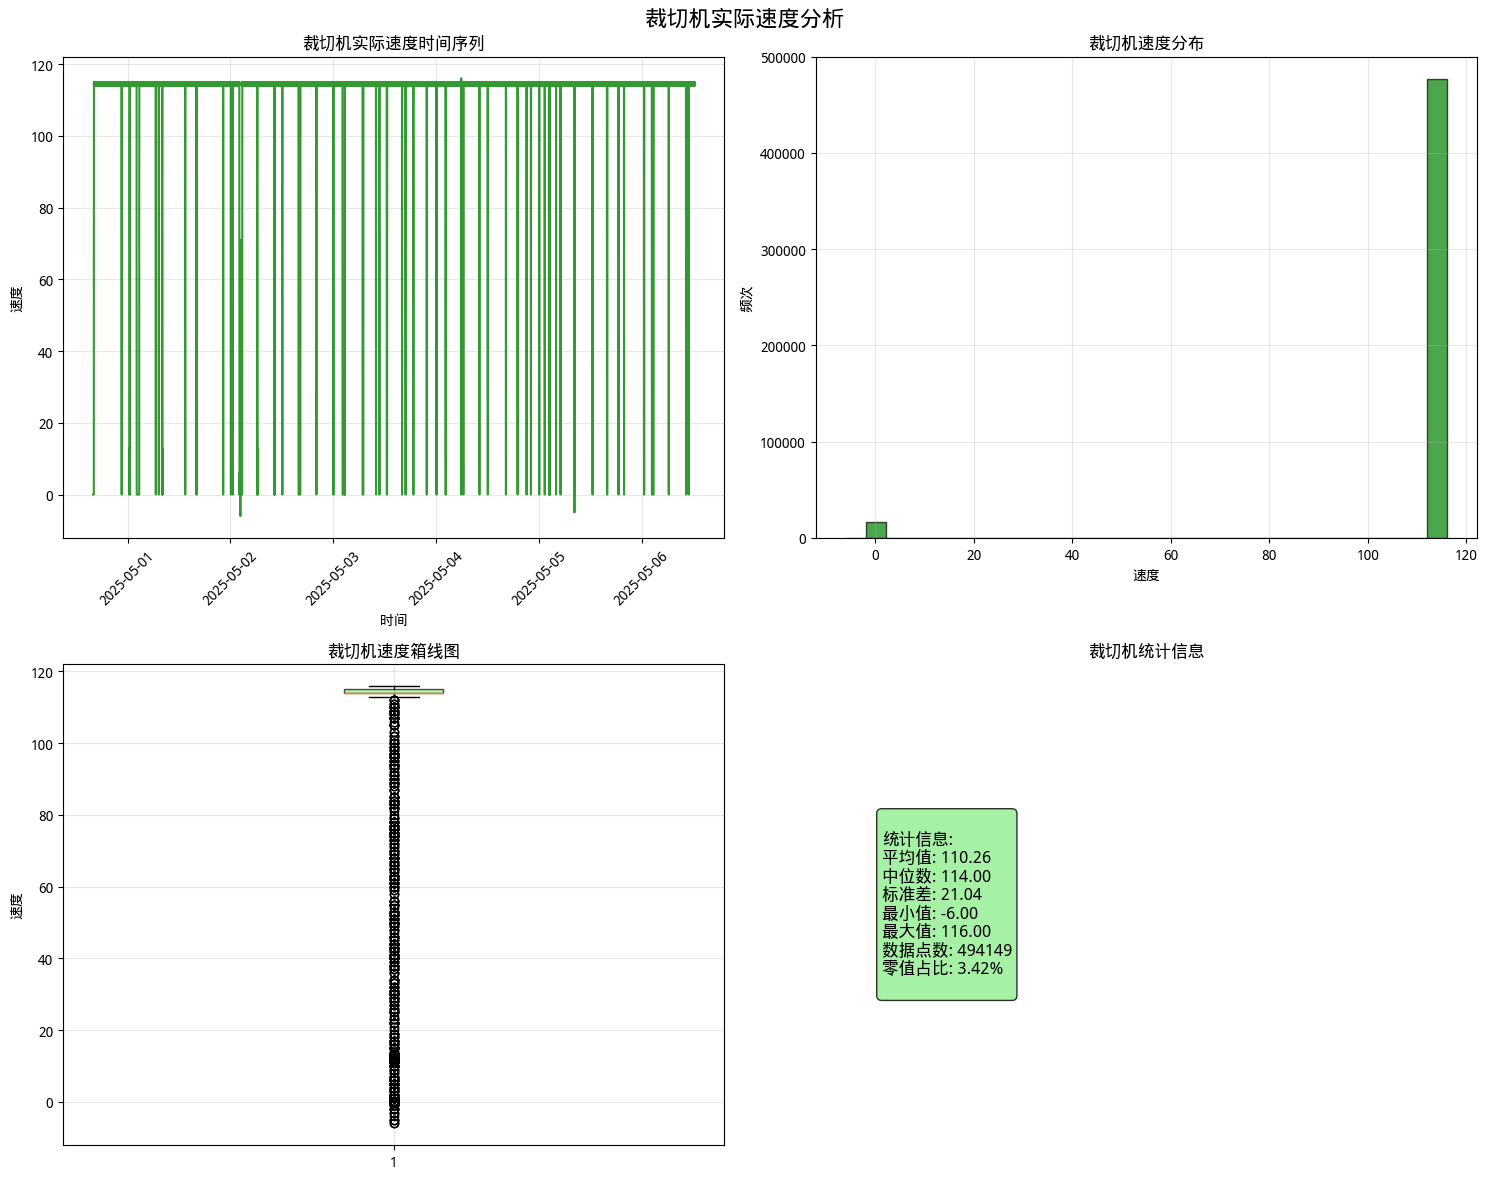

裁切机速度变化范围: 122.00
裁切机平均速度: 110.26
裁切机运行时间占比: 96.58%

发现 17724 个异常值:
            timestamp  value
0 2025-04-30 16:00:00    0.0
1 2025-04-30 16:00:01    0.0
2 2025-04-30 16:00:02    0.0
3 2025-04-30 16:00:03    0.0
4 2025-04-30 16:00:04    0.0

图表已保存到: script/裁切机速度分析图表.png


<Figure size 640x480 with 0 Axes>

In [8]:
# 添加裁切机实际速度分析
print("\n=== 裁切机实际速度分析 ===")

# 读取裁切机数据
caiqie_file = Path("各点位/裁切机实际速度.csv")
if caiqie_file.exists():
    df_caiqie = pd.read_csv(caiqie_file)

    # 标准化列名
    if '时间' in df_caiqie.columns:
        df_caiqie = df_caiqie.rename(columns={'时间': 'timestamp'})
    value_columns = [col for col in df_caiqie.columns if col != 'timestamp']
    if value_columns:
        df_caiqie = df_caiqie.rename(columns={value_columns[0]: 'value'})

    df_caiqie['timestamp'] = pd.to_datetime(df_caiqie['timestamp'])
    
    # 创建裁切机速度分析图
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('裁切机实际速度分析', fontsize=16, fontweight='bold')
    
    # 1. 时间序列图
    axes[0, 0].plot(df_caiqie['timestamp'], df_caiqie['value'], 
                    color='green', linewidth=1.5, alpha=0.8)
    axes[0, 0].set_title('裁切机实际速度时间序列')
    axes[0, 0].set_xlabel('时间')
    axes[0, 0].set_ylabel('速度')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. 速度分布直方图
    axes[0, 1].hist(df_caiqie['value'], bins=30, color='green', alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('裁切机速度分布')
    axes[0, 1].set_xlabel('速度')
    axes[0, 1].set_ylabel('频次')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. 速度箱线图
    axes[1, 0].boxplot(df_caiqie['value'], patch_artist=True, 
                       boxprops=dict(facecolor='lightgreen', alpha=0.7))
    axes[1, 0].set_title('裁切机速度箱线图')
    axes[1, 0].set_ylabel('速度')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. 裁切机统计信息
    stats_text = f"""
统计信息:
平均值: {df_caiqie['value'].mean():.2f}
中位数: {df_caiqie['value'].median():.2f}
标准差: {df_caiqie['value'].std():.2f}
最小值: {df_caiqie['value'].min():.2f}
最大值: {df_caiqie['value'].max():.2f}
数据点数: {len(df_caiqie)}
零值占比: {(df_caiqie['value'] == 0).sum() / len(df_caiqie) * 100:.2f}%
"""
    
    axes[1, 1].text(0.1, 0.5, stats_text, transform=axes[1, 1].transAxes, 
                    fontsize=12, verticalalignment='center',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.8))
    axes[1, 1].set_title('裁切机统计信息')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 额外分析：裁切机趋势分析
    print(f"裁切机速度变化范围: {df_caiqie['value'].max() - df_caiqie['value'].min():.2f}")
    print(f"裁切机平均速度: {df_caiqie['value'].mean():.2f}")
    print(f"裁切机运行时间占比: {(df_caiqie['value'] > 0).sum() / len(df_caiqie) * 100:.2f}%")
    
    # 检查是否有异常值
    Q1 = df_caiqie['value'].quantile(0.25)
    Q3 = df_caiqie['value'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df_caiqie[(df_caiqie['value'] < lower_bound) | 
                        (df_caiqie['value'] > upper_bound)]
    
    if len(outliers) > 0:
        print(f"\n发现 {len(outliers)} 个异常值:")
        print(outliers[['timestamp', 'value']].head())
    else:
        print("\n未发现异常值")
    
    # 保存图表
    output_fig = script_dir / "裁切机速度分析图表.png"
    plt.savefig(output_fig, dpi=300, bbox_inches='tight')
    print(f"\n图表已保存到: {output_fig}")
    
else:
    print("警告: 裁切机实际速度.csv 文件不存在")



处理裁切机数据...
已生成 200 个状态改变事件
事件数据已保存到: script/裁切机_events.json

裁切机前5个状态改变事件示例:
事件 1: 时间=2025-04-30 16:00:00, 速度=0.00, 状态变化: None -> 停机
事件 2: 时间=2025-04-30 16:08:31, 速度=110.00, 状态变化: 停机 -> 生产
事件 3: 时间=2025-04-30 22:37:34, 速度=26.00, 状态变化: 生产 -> 待机
事件 4: 时间=2025-04-30 22:37:37, 速度=0.00, 状态变化: 待机 -> 停机
事件 5: 时间=2025-04-30 22:38:39, 速度=83.00, 状态变化: 停机 -> 生产


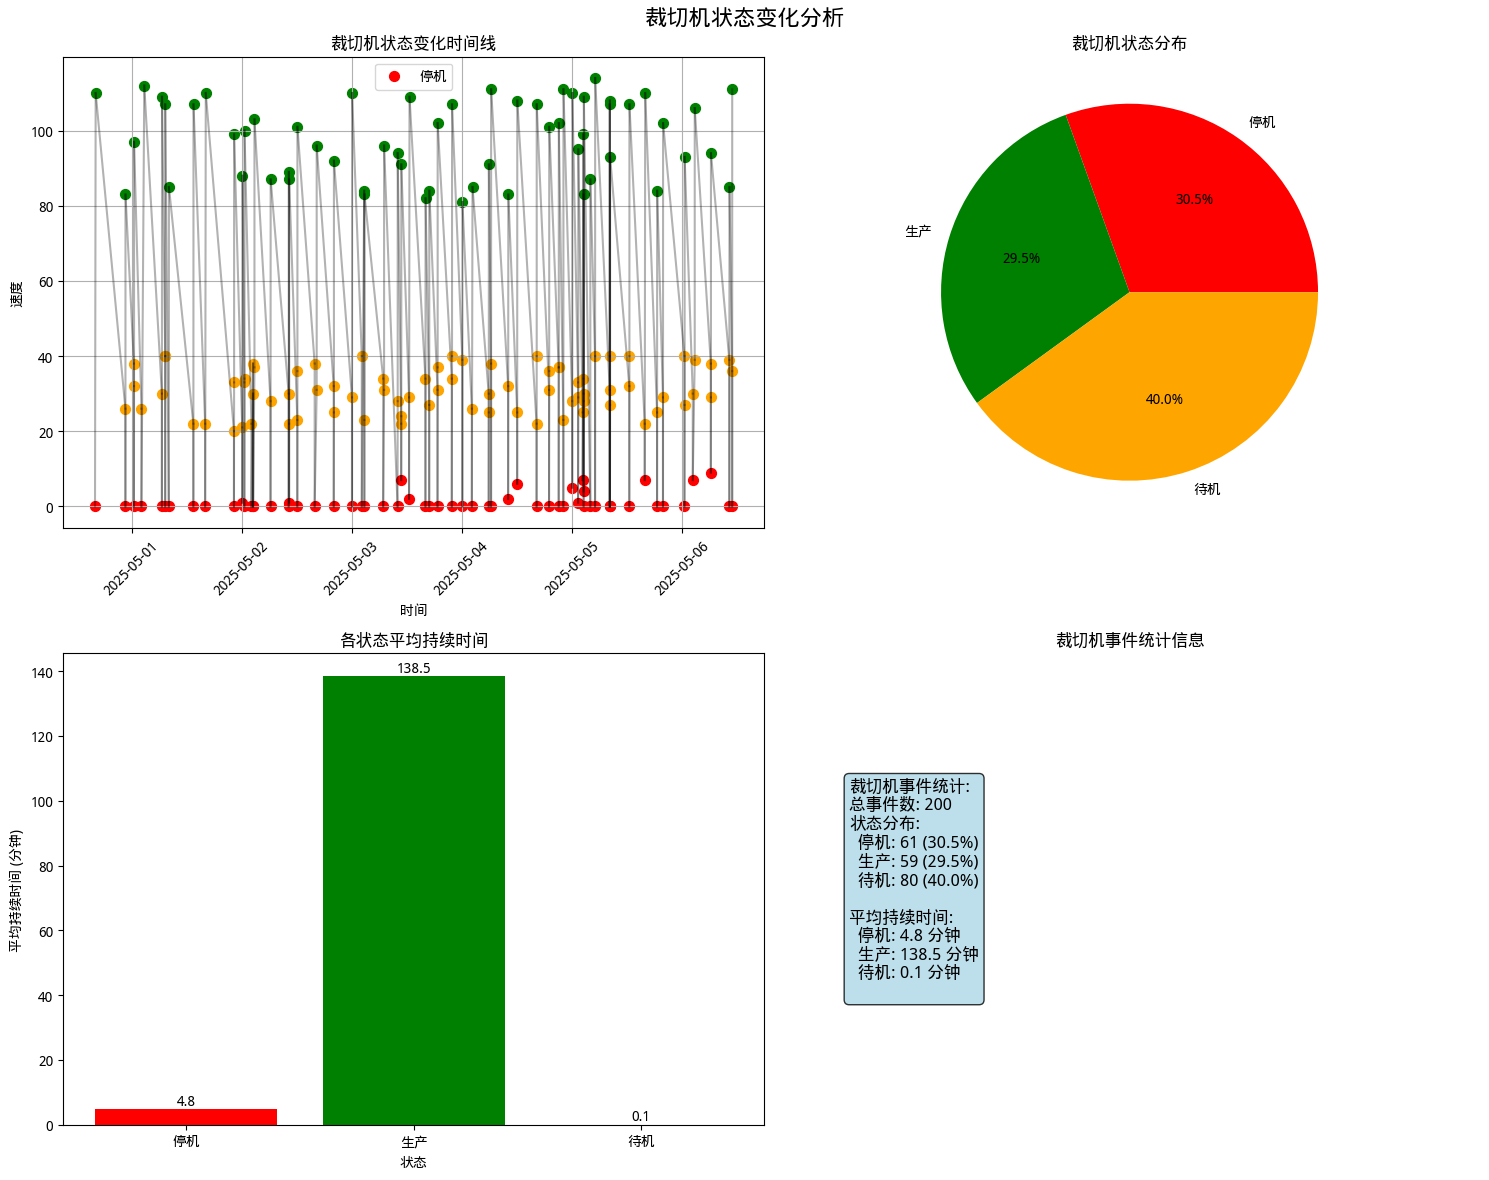


裁切机事件数据处理完成！


In [9]:
# 处理裁切机数据，将速度转换为事件
import json
import os
from datetime import datetime, timedelta

def convert_caiqie_speed_to_events(df, device_id="裁切机"):
    """
    将裁切机速度数据转换为事件数据，只记录状态改变
    
    Args:
        df: 包含timestamp和value列的DataFrame
        device_id: 设备ID，默认为"裁切机"
    """
    events = []
    
    # 确保数据按时间排序
    df = df.sort_values('timestamp').reset_index(drop=True)
    
    # 初始化状态
    current_status = None
    
    for idx, row in df.iterrows():
        speed_value = row['value']
        timestamp = row['timestamp']
        
        # 根据速度值确定设备状态
        if speed_value < 10:
            new_status = "停机"
        elif 20 <= speed_value <= 40:
            new_status = "待机"
        elif speed_value > 80:
            new_status = "生产"
        else:
            continue
        
        # 只有当状态发生改变时才记录事件
        if new_status != current_status:
            event = {
                "timestamp": timestamp.strftime("%Y-%m-%d %H:%M:%S"),
                "events": [
                    {
                        "event_type": "status_change",
                        "deviceID": device_id,
                        "params": {
                            "speed": float(speed_value),
                            "status": new_status,
                            "previous_status": current_status
                        }
                    }
                ]
            }
            events.append(event)
            current_status = new_status
    
    return events

# 处理裁切机数据
caiqie_data_path = "各点位/裁切机实际速度.csv"

if os.path.exists(caiqie_data_path):
    print("\n处理裁切机数据...")
    
    # 读取裁切机数据
    df_caiqie = pd.read_csv(caiqie_data_path)
    
    # 标准化列名
    if '时间' in df_caiqie.columns:
        df_caiqie = df_caiqie.rename(columns={'时间': 'timestamp'})
    
    value_columns = [col for col in df_caiqie.columns if col != 'timestamp']
    if value_columns:
        df_caiqie = df_caiqie.rename(columns={value_columns[0]: 'value'})
    
    # 转换时间格式并处理数值
    df_caiqie['timestamp'] = pd.to_datetime(df_caiqie['timestamp'])
    df_caiqie['value'] = pd.to_numeric(df_caiqie['value'], errors='coerce')
    df_caiqie = df_caiqie.dropna().sort_values('timestamp')
    
    # 转换事件数据
    caiqie_events = convert_caiqie_speed_to_events(df_caiqie, "裁切机")
    
    # 保存事件数据
    output_file = "script/裁切机_events.json"
    os.makedirs("script", exist_ok=True)
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(caiqie_events, f, ensure_ascii=False, indent=2)
    
    print(f"已生成 {len(caiqie_events)} 个状态改变事件")
    print(f"事件数据已保存到: {output_file}")
    
    # 显示前几个事件作为示例
    print(f"\n裁切机前5个状态改变事件示例:")
    for i, event in enumerate(caiqie_events[:5]):
        speed = event['events'][0]['params']['speed']
        status = event['events'][0]['params']['status']
        prev_status = event['events'][0]['params']['previous_status']
        timestamp = event['timestamp']
        print(f"事件 {i+1}: 时间={timestamp}, 速度={speed:.2f}, 状态变化: {prev_status} -> {status}")
    
    # 可视化裁切机状态变化
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('裁切机状态变化分析', fontsize=16)
    
    colors = {'停机': 'red', '待机': 'orange', '生产': 'green'}
    
    # 提取状态变化数据
    timestamps = [pd.to_datetime(event['timestamp']) for event in caiqie_events]
    statuses = [event['events'][0]['params']['status'] for event in caiqie_events]
    speeds = [event['events'][0]['params']['speed'] for event in caiqie_events]
    
    # 绘制状态变化时间线
    ax1 = axes[0, 0]
    for i, status in enumerate(statuses):
        ax1.scatter(timestamps[i], speeds[i], c=colors[status], label=status if i == 0 else "", s=50)
        if i > 0:
            ax1.plot([timestamps[i-1], timestamps[i]], [speeds[i-1], speeds[i]], 'k-', alpha=0.3)
    
    ax1.set_xlabel('时间')
    ax1.set_ylabel('速度')
    ax1.set_title('裁切机状态变化时间线')
    ax1.legend()
    ax1.grid(True)
    ax1.tick_params(axis='x', rotation=45)
    
    # 绘制状态分布饼图
    ax2 = axes[0, 1]
    status_counts = {}
    for status in statuses:
        status_counts[status] = status_counts.get(status, 0) + 1
    
    if status_counts:
        ax2.pie(status_counts.values(), labels=status_counts.keys(), autopct='%1.1f%%', 
               colors=[colors.get(status, 'gray') for status in status_counts.keys()])
        ax2.set_title('裁切机状态分布')
    
    # 绘制状态持续时间分析
    ax3 = axes[1, 0]
    status_durations = {}
    for i in range(1, len(timestamps)):
        duration = (timestamps[i] - timestamps[i-1]).total_seconds() / 60  # 转换为分钟
        prev_status = statuses[i-1]
        if prev_status not in status_durations:
            status_durations[prev_status] = []
        status_durations[prev_status].append(duration)
    
    if status_durations:
        status_names = list(status_durations.keys())
        avg_durations = [sum(status_durations[status])/len(status_durations[status]) 
                        for status in status_names]
        bars = ax3.bar(status_names, avg_durations, 
                      color=[colors.get(status, 'gray') for status in status_names])
        ax3.set_xlabel('状态')
        ax3.set_ylabel('平均持续时间 (分钟)')
        ax3.set_title('各状态平均持续时间')
        
        # 在柱状图上显示数值
        for bar, duration in zip(bars, avg_durations):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{duration:.1f}', ha='center', va='bottom')
    
    # 显示统计信息
    ax4 = axes[1, 1]
    stats_text = f"""裁切机事件统计:
总事件数: {len(caiqie_events)}
状态分布:
"""
    for status, count in status_counts.items():
        percentage = count / len(caiqie_events) * 100
        stats_text += f"  {status}: {count} ({percentage:.1f}%)\n"
    
    if status_durations:
        stats_text += "\n平均持续时间:\n"
        for status, durations in status_durations.items():
            avg_duration = sum(durations) / len(durations)
            stats_text += f"  {status}: {avg_duration:.1f} 分钟\n"
    
    ax4.text(0.1, 0.5, stats_text, transform=ax4.transAxes, 
            fontsize=12, verticalalignment='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8))
    ax4.set_title('裁切机事件统计信息')
    ax4.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n裁切机事件数据处理完成！")
    
else:
    print("警告: 裁切机实际速度.csv 文件不存在")


=== 设备事件数据统计 ===
统计文件夹: script
统计文件: 折叠机_events.json, 裁切机_events.json, xbj1_events.json, xbj2_events.json, xbj3_events.json, xbj4_events.json

折叠机:
  事件总数: 509
  时间范围: 2025-04-30 16:00:00 至 2025-05-06 11:14:33
  时间跨度: 5 天 (139.2 小时)
  状态分布: 生产(122) 待机(254) 停机(133)

裁切机:
  事件总数: 200
  时间范围: 2025-04-30 16:00:00 至 2025-05-06 10:53:07
  时间跨度: 5 天 (138.9 小时)
  状态分布: 生产(59) 待机(80) 停机(61)

xbj1:
  事件总数: 1029
  时间范围: 2025-04-30 16:00:00 至 2025-05-06 12:08:51
  时间跨度: 5 天 (140.1 小时)
  状态分布: 生产(432) 待机(275) 停机(322)

xbj2:
  事件总数: 1902
  时间范围: 2025-04-30 16:00:00 至 2025-05-06 12:01:24
  时间跨度: 5 天 (140.0 小时)
  状态分布: 生产(714) 待机(700) 停机(488)

xbj3:
  事件总数: 2082
  时间范围: 2025-04-30 16:00:00 至 2025-05-06 11:35:26
  时间跨度: 5 天 (139.6 小时)
  状态分布: 生产(866) 待机(845) 停机(371)

xbj4:
  事件总数: 1763
  时间范围: 2025-04-30 16:00:00 至 2025-05-06 12:06:05
  时间跨度: 5 天 (140.1 小时)
  状态分布: 生产(631) 待机(617) 停机(515)

=== 总体统计 ===
总事件数: 7485
统计设备数: 6


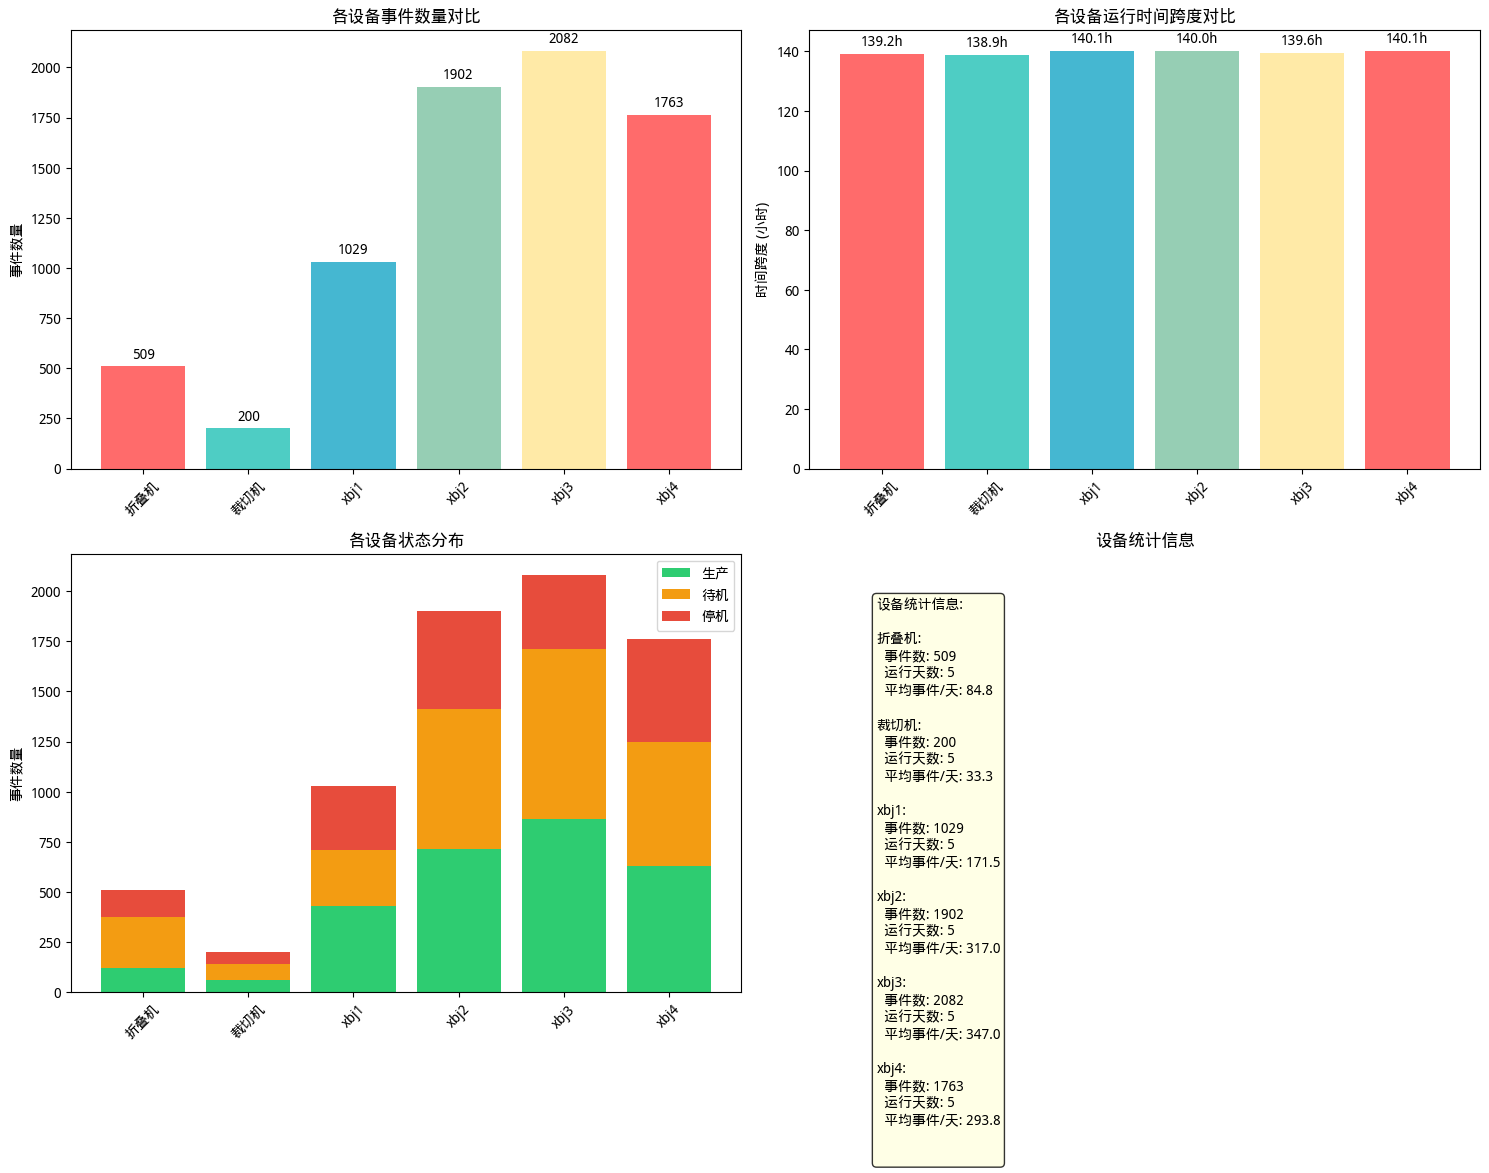


图表已保存到: script/设备事件统计图表.png

=== 事件数据详细分析 ===
总事件记录数: 7485
时间范围: 2025-04-30 16:00:00 至 2025-05-06 12:08:51

各设备状态统计:
status   停机   待机   生产
device               
xbj1    322  275  432
xbj2    488  700  714
xbj3    371  845  866
xbj4    515  617  631
折叠机     133  254  122
裁切机      61   80   59

各设备状态占比(%):
status    停机    待机    生产
device                  
xbj1    31.3  26.7  42.0
xbj2    25.7  36.8  37.5
xbj3    17.8  40.6  41.6
xbj4    29.2  35.0  35.8
折叠机     26.1  49.9  24.0
裁切机     30.5  40.0  29.5

各设备日均事件数:
  xbj1: 147.0 事件/天
  xbj2: 271.7 事件/天
  xbj3: 297.4 事件/天
  xbj4: 251.9 事件/天
  折叠机: 72.7 事件/天
  裁切机: 28.6 事件/天


<Figure size 640x480 with 0 Axes>

In [10]:
# 统计script文件夹下的设备事件数据
import json
from pathlib import Path
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# 获取script文件夹路径
script_dir = Path("script")

# 定义要统计的文件
files_to_analyze = [
    "折叠机_events.json",
    "裁切机_events.json",
    "xbj1_events.json", 
    "xbj2_events.json",
    "xbj3_events.json",
    "xbj4_events.json"
]

print("=== 设备事件数据统计 ===")
print(f"统计文件夹: {script_dir}")
print(f"统计文件: {', '.join(files_to_analyze)}")
print("=" * 50)

total_events = 0
device_stats = {}
all_events_data = []

# 遍历每个文件进行统计
for filename in files_to_analyze:
    file_path = script_dir / filename
    
    if not file_path.exists():
        print(f"警告: 文件 {filename} 不存在")
        continue
    
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        # 统计该设备的事件信息
        device_name = filename.replace('_events.json', '')
        event_count = len(data)
        total_events += event_count
        
        # 提取时间信息
        timestamps = [item['timestamp'] for item in data]
        if timestamps:
            start_time = min(timestamps)
            end_time = max(timestamps)
            
            # 转换为datetime对象计算时间跨度
            start_dt = datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S")
            end_dt = datetime.strptime(end_time, "%Y-%m-%d %H:%M:%S")
            time_span = end_dt - start_dt
            
            # 统计各种状态的事件数量
            status_counts = {'生产': 0, '待机': 0, '停机': 0}
            for item in data:
                for event in item['events']:
                    if 'params' in event and 'status' in event['params']:
                        status = event['params']['status']
                        if status in status_counts:
                            status_counts[status] += 1
            
            device_stats[device_name] = {
                'event_count': event_count,
                'start_time': start_time,
                'end_time': end_time,
                'time_span_days': time_span.days,
                'time_span_hours': time_span.total_seconds() / 3600,
                'status_counts': status_counts
            }
            
            # 收集所有事件数据用于后续分析
            for item in data:
                for event in item['events']:
                    event_data = {
                        'device': device_name,
                        'timestamp': item['timestamp'],
                        'event_type': event['event_type'],
                        'deviceID': event.get('deviceID', device_name)
                    }
                    if 'params' in event:
                        event_data.update(event['params'])
                    all_events_data.append(event_data)
        
        print(f"\n{device_name}:")
        print(f"  事件总数: {event_count}")
        print(f"  时间范围: {start_time} 至 {end_time}")
        print(f"  时间跨度: {time_span.days} 天 ({time_span.total_seconds()/3600:.1f} 小时)")
        print(f"  状态分布: 生产({status_counts['生产']}) 待机({status_counts['待机']}) 停机({status_counts['停机']})")
        
    except Exception as e:
        print(f"读取文件 {filename} 时出错: {e}")

print(f"\n=== 总体统计 ===")
print(f"总事件数: {total_events}")
print(f"统计设备数: {len(device_stats)}")

# 创建可视化图表
if device_stats:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. 各设备事件数量对比
    devices = list(device_stats.keys())
    event_counts = [device_stats[device]['event_count'] for device in devices]
    
    axes[0, 0].bar(devices, event_counts, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
    axes[0, 0].set_title('各设备事件数量对比')
    axes[0, 0].set_ylabel('事件数量')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 在柱状图上显示数值
    for i, v in enumerate(event_counts):
        axes[0, 0].text(i, v + max(event_counts)*0.01, str(v), ha='center', va='bottom')
    
    # 2. 各设备运行时间跨度对比
    time_spans = [device_stats[device]['time_span_hours'] for device in devices]
    
    axes[0, 1].bar(devices, time_spans, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
    axes[0, 1].set_title('各设备运行时间跨度对比')
    axes[0, 1].set_ylabel('时间跨度 (小时)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 在柱状图上显示数值
    for i, v in enumerate(time_spans):
        axes[0, 1].text(i, v + max(time_spans)*0.01, f'{v:.1f}h', ha='center', va='bottom')
    
    # 3. 各设备状态分布堆叠柱状图
    status_data = {
        '生产': [device_stats[device]['status_counts']['生产'] for device in devices],
        '待机': [device_stats[device]['status_counts']['待机'] for device in devices],
        '停机': [device_stats[device]['status_counts']['停机'] for device in devices]
    }
    
    bottom_production = [0] * len(devices)
    bottom_standby = status_data['生产']
    
    axes[1, 0].bar(devices, status_data['生产'], label='生产', color='#2ECC71')
    axes[1, 0].bar(devices, status_data['待机'], bottom=bottom_standby, label='待机', color='#F39C12')
    axes[1, 0].bar(devices, status_data['停机'], 
                   bottom=[sum(x) for x in zip(status_data['生产'], status_data['待机'])], 
                   label='停机', color='#E74C3C')
    
    axes[1, 0].set_title('各设备状态分布')
    axes[1, 0].set_ylabel('事件数量')
    axes[1, 0].legend()
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # 4. 统计信息表格
    stats_text = "设备统计信息:\n\n"
    for device in devices:
        stats = device_stats[device]
        stats_text += f"{device}:\n"
        stats_text += f"  事件数: {stats['event_count']}\n"
        stats_text += f"  运行天数: {stats['time_span_days']}\n"
        stats_text += f"  平均事件/天: {stats['event_count']/(stats['time_span_days']+1):.1f}\n\n"
    
    axes[1, 1].text(0.1, 0.9, stats_text, transform=axes[1, 1].transAxes, 
                    fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8))
    axes[1, 1].set_title('设备统计信息')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 保存图表
    output_fig = script_dir / "设备事件统计图表.png"
    plt.savefig(output_fig, dpi=300, bbox_inches='tight')
    print(f"\n图表已保存到: {output_fig}")

# 创建事件数据的DataFrame用于进一步分析
if all_events_data:
    df_events = pd.DataFrame(all_events_data)
    df_events['timestamp'] = pd.to_datetime(df_events['timestamp'])
    
    print(f"\n=== 事件数据详细分析 ===")
    print(f"总事件记录数: {len(df_events)}")
    print(f"时间范围: {df_events['timestamp'].min()} 至 {df_events['timestamp'].max()}")
    
    # 按设备和状态统计
    if 'status' in df_events.columns:
        status_summary = df_events.groupby(['device', 'status']).size().unstack(fill_value=0)
        print(f"\n各设备状态统计:")
        print(status_summary)
        
        # 计算各设备的状态占比
        status_percentage = status_summary.div(status_summary.sum(axis=1), axis=0) * 100
        print(f"\n各设备状态占比(%):")
        print(status_percentage.round(1))
    
    # 按日期统计事件频率
    df_events['date'] = df_events['timestamp'].dt.date
    daily_events = df_events.groupby(['device', 'date']).size().reset_index(name='event_count')
    
    print(f"\n各设备日均事件数:")
    daily_avg = daily_events.groupby('device')['event_count'].mean()
    for device, avg_count in daily_avg.items():
        print(f"  {device}: {avg_count:.1f} 事件/天")




In [11]:
# 合并所有设备事件数据为统一格式
print("\n=== 合并所有设备事件数据 ===")

# 定义设备名称列表
device_names = ['折叠机', '裁切机', 'xbj1', 'xbj2', 'xbj3', 'xbj4']

# 重新加载所有设备的事件数据
all_device_events = []
for device_name in device_names:
    json_file = script_dir / f"{device_name}_events.json"
    if json_file.exists():
        with open(json_file, 'r', encoding='utf-8') as f:
            device_data = json.load(f)
            all_device_events.append(device_data)
            print(f"加载 {device_name} 事件数据: {len(device_data)} 条记录")
    else:
        print(f"警告: 未找到 {device_name} 的事件文件")
        all_device_events.append([])

# 创建合并后的事件数据结构
merged_events = []

# 遍历所有设备的事件数据
for device_name, events_data in zip(device_names, all_device_events):
    if events_data:  # 确保有数据
        for item in events_data:
            # 为每个时间点的事件添加设备信息
            timestamp = item['timestamp']
            for event in item['events']:
                merged_event = {
                    'timestamp': timestamp,
                    'device': device_name,
                    'event_type': event['event_type'],
                    'deviceID': event.get('deviceID', device_name)
                }
                
                # 添加事件参数
                if 'params' in event:
                    merged_event.update(event['params'])
                
                merged_events.append(merged_event)

# 按时间排序
merged_events.sort(key=lambda x: x['timestamp'])

print(f"合并完成，共 {len(merged_events)} 个事件记录")
print(f"时间范围: {merged_events[0]['timestamp'] if merged_events else 'N/A'} 至 {merged_events[-1]['timestamp'] if merged_events else 'N/A'}")

# 保存合并后的事件数据
merged_output_path = script_dir / "merged_all_events.json"
with open(merged_output_path, 'w', encoding='utf-8') as f:
    json.dump(merged_events, f, ensure_ascii=False, indent=2)

print(f"合并后的事件数据已保存到: {merged_output_path}")

# 显示合并数据的统计信息
if merged_events:
    print(f"\n=== 合并数据统计 ===")
    
    # 按设备统计事件数量
    device_event_counts = {}
    for event in merged_events:
        device = event['device']
        device_event_counts[device] = device_event_counts.get(device, 0) + 1
    
    print("各设备事件数量:")
    for device, count in device_event_counts.items():
        print(f"  {device}: {count} 个事件")
    
    # 按事件类型统计
    event_type_counts = {}
    for event in merged_events:
        event_type = event['event_type']
        event_type_counts[event_type] = event_type_counts.get(event_type, 0) + 1
    
    print(f"\n事件类型统计:")
    for event_type, count in event_type_counts.items():
        print(f"  {event_type}: {count} 个事件")
    
    # 显示前5个事件示例
    print(f"\n前5个合并事件示例:")
    for i, event in enumerate(merged_events[:5], 1):
        print(f"事件 {i}:")
        print(f"  时间: {event['timestamp']}")
        print(f"  设备: {event['device']}")
        print(f"  事件类型: {event['event_type']}")
        if 'status' in event:
            print(f"  状态: {event['status']}")
        if 'speed' in event:
            print(f"  速度: {event['speed']}")
        if 'previous_status' in event:
            print(f"  前一状态: {event['previous_status']}")
        print()

# 创建用于仿真的简化数据格式
simulation_events = []
for event in merged_events:
    sim_event = {
        'timestamp': event['timestamp'],
        'device_id': event['deviceID'],
        'event_type': event['event_type']
    }
    
    # 添加关键参数
    if 'status' in event:
        sim_event['status'] = event['status']
    if 'speed' in event:
        sim_event['speed'] = event['speed']
    if 'previous_status' in event:
        sim_event['previous_status'] = event['previous_status']
    
    simulation_events.append(sim_event)

# 保存仿真用数据
simulation_output_path = script_dir / "simulation_events.json"
with open(simulation_output_path, 'w', encoding='utf-8') as f:
    json.dump(simulation_events, f, ensure_ascii=False, indent=2)

print(f"仿真用事件数据已保存到: {simulation_output_path}")
print(f"仿真数据包含 {len(simulation_events)} 个事件记录")




=== 合并所有设备事件数据 ===
加载 折叠机 事件数据: 509 条记录
加载 裁切机 事件数据: 200 条记录
加载 xbj1 事件数据: 1029 条记录
加载 xbj2 事件数据: 1902 条记录
加载 xbj3 事件数据: 2082 条记录
加载 xbj4 事件数据: 1763 条记录
合并完成，共 7485 个事件记录
时间范围: 2025-04-30 16:00:00 至 2025-05-06 12:08:51
合并后的事件数据已保存到: script/merged_all_events.json

=== 合并数据统计 ===
各设备事件数量:
  折叠机: 509 个事件
  裁切机: 200 个事件
  xbj1: 1029 个事件
  xbj2: 1902 个事件
  xbj3: 2082 个事件
  xbj4: 1763 个事件

事件类型统计:
  status_change: 7485 个事件

前5个合并事件示例:
事件 1:
  时间: 2025-04-30 16:00:00
  设备: 折叠机
  事件类型: status_change
  状态: 停机
  速度: 0.0
  前一状态: None

事件 2:
  时间: 2025-04-30 16:00:00
  设备: 裁切机
  事件类型: status_change
  状态: 停机
  速度: 0.0
  前一状态: None

事件 3:
  时间: 2025-04-30 16:00:00
  设备: xbj1
  事件类型: status_change
  状态: 停机
  速度: 0.0
  前一状态: None

事件 4:
  时间: 2025-04-30 16:00:00
  设备: xbj2
  事件类型: status_change
  状态: 停机
  速度: 0.0
  前一状态: None

事件 5:
  时间: 2025-04-30 16:00:00
  设备: xbj3
  事件类型: status_change
  状态: 停机
  速度: 0.0
  前一状态: None

仿真用事件数据已保存到: script/simulation_events.json
仿真数据包含 7485 个事件记录


In [39]:
# 从merged_all_events.json读取数据并转换为CSV格式
merged_events_file = script_dir / "merged_all_events.json"

def determine_status(device_id, latest_value):
    """
    根据设备ID和最新数值确定设备状态
    
    Args:
        device_id (str): 设备标识符
        latest_value (float): 最新的数值（通常是速度）
    
    Returns:
        str: 设备状态 ('停机', '待机', '生产')
    """
    if latest_value is None:
        return '停机'
    
    # 根据不同设备设置不同的阈值
    if device_id in ['XBJ1', 'XBJ2', 'XBJ3', 'XBJ4']:
        # 压边机系列的状态判断
        if latest_value <= 5:
            return '停机'
        elif latest_value <= 30:
            return '待机'
        else:
            return '生产'
    
    elif device_id == '裁切机':
        # 裁切机的状态判断
        if latest_value <= 3:
            return '停机'
        elif latest_value <= 25:
            return '待机'
        else:
            return '生产'
    
    elif device_id == '折叠机':
        # 折叠机的状态判断
        if latest_value <= 5:
            return '停机'
        elif latest_value <= 30:
            return '待机'
        else:
            return '生产'
    
    else:
        # 默认状态判断（适用于未知设备）
        if latest_value <= 5:
            return '停机'
        elif latest_value <= 25:
            return '待机'
        else:
            return '生产'


if merged_events_file.exists():
    print(f"正在从 {merged_events_file} 读取合并事件数据...")
    with open(merged_events_file, 'r', encoding='utf-8') as f:
        merged_events = json.load(f)
    
    print(f"成功读取 {len(merged_events)} 个合并事件")
    
    # 将事件数据转换为DataFrame
    events_df = pd.DataFrame(merged_events)
    
    # 转换时间戳为datetime类型
    events_df['timestamp'] = pd.to_datetime(events_df['timestamp'])
    
    # 获取所有设备ID
    device_ids = list(set(events_df['deviceID'].unique()))
    print(f"发现设备: {device_ids}")
    
    # 创建时间范围
    start_time = events_df['timestamp'].min()
    end_time = events_df['timestamp'].max()
    
    # 按时间分组，创建透视表结构
    # 为每个设备创建状态和速度的列
    pivot_data = []
    
    # 获取所有唯一的时间戳
    unique_timestamps = sorted(events_df['timestamp'].unique())
    
    # 为每个时间戳创建一行数据
    for timestamp in unique_timestamps:
        row_data = {'timestamp': timestamp}
        
        # 获取该时间戳的所有事件
        timestamp_events = events_df[events_df['timestamp'] == timestamp]
        
        # 为每个设备初始化列
        for device_id in device_ids:
            row_data[f'{device_id}_status'] = None
            row_data[f'{device_id}_speed'] = None
        
        # 填充该时间戳的设备数据
        for _, event in timestamp_events.iterrows():
            device_id = event['deviceID']
            if pd.notna(event.get('status')):
                row_data[f'{device_id}_status'] = event['status']
            if pd.notna(event.get('speed')):
                row_data[f'{device_id}_speed'] = event['speed']
        
        pivot_data.append(row_data)
    
    # 创建透视表DataFrame
    pivot_df = pd.DataFrame(pivot_data)


    # 对pivot_df中的空字段进行填充
    print("\n开始填充空字段...")
    
    # 定义设备名称到CSV文件名的映射
    device_csv_mapping = {
        'XBJ1': '1#小包机实际速度.csv',
        'XBJ2': '2#小包机实际速度.csv', 
        'XBJ3': '3#小包机实际速度.csv',
        'XBJ4': '4#小包机实际速度.csv',
        '存纸架': '存纸率.csv',
        '裁切机': '裁切机实际速度.csv',
        '折叠机': '折叠机实际速度.csv'
    }
    
    # 为每个设备读取对应的CSV文件并填充数据
    for device_id in device_ids:
        print(device_id)
        if device_id in device_csv_mapping:
            # 构建设备对应的CSV文件路径
            csv_filename = device_csv_mapping[device_id]
            device_csv_file =  Path("各点位") / str(csv_filename)

            print(device_csv_file)
            
            if device_csv_file.exists():
                print(f"正在处理设备 {device_id} 的数据，文件: {csv_filename}")
                
                # 读取设备CSV文件，这些文件只有两列：时间戳和数值
                device_df = pd.read_csv(device_csv_file)

                print(device_df.head())
                 # 标准化列名
                if '时间' in device_df.columns:
                    device_df = device_df.rename(columns={'时间': 'timestamp'})
                value_columns = [col for col in device_df.columns if col != 'timestamp']
                if value_columns:
                    device_df = device_df.rename(columns={value_columns[0]: 'value'})
                print(device_df.head())
                device_df['timestamp'] = pd.to_datetime(device_df['timestamp'])
                
                # 为该设备的每个时间戳填充数据
                for idx, row in pivot_df.iterrows():
                    timestamp = row['timestamp']
                    status_col = f'{device_id}_status'
                    speed_col = f'{device_id}_speed'
                    
                    # 如果当前位置的状态或速度为空，尝试从设备CSV中获取数据
                    if pd.isna(row[status_col]) or pd.isna(row[speed_col]):
                        # 查找该时间戳在设备CSV中的数据
                        device_data = device_df[device_df['timestamp'] == timestamp]
                        
                        if not device_data.empty:
                            # 如果找到对应时间的数据，填充速度值
                            latest_value = device_data['value'].iloc[-1]  # 取最新的数值
                            if pd.notna(latest_value):
                                if pd.isna(row[speed_col]):
                                    pivot_df.at[idx, speed_col] = latest_value
                                # 对于状态，可以根据数值设置运行状态
                                if pd.isna(row[status_col]):
                                    pivot_df.at[idx, status_col] = determine_status(device_id, latest_value)
                        else:
                            # 如果没有找到对应时间的数据，使用前向填充方法
                            # 查找该时间戳之前最近的数据
                            before_data = device_df[device_df['timestamp'] < timestamp].sort_values('timestamp')
                            
                            if not before_data.empty:
                                latest_value = before_data['value'].iloc[-1]
                                if pd.notna(latest_value):
                                    if pd.isna(row[speed_col]):
                                        pivot_df.at[idx, speed_col] = latest_value
                                    # if pd.isna(row[status_col]):
                                    #     pivot_df.at[idx, status_col] = '运行' if latest_value > 0 else '停止'
            else:
                print(f"警告: 找不到设备 {device_id} 的CSV文件: {device_csv_file}")
        else:
            print(f"警告: 设备 {device_id} 没有对应的CSV文件映射")
    
    # 添加存纸率列
    print("\n正在添加存纸率数据...")
    paper_storage_file = Path("各点位") / "存纸率.csv"
    
    if paper_storage_file.exists():
        print(f"正在读取存纸率数据: {paper_storage_file}")
        
        # 读取存纸率CSV文件
        paper_df = pd.read_csv(paper_storage_file)
        print(paper_df.head())
        
        # 标准化列名
        if '时间' in paper_df.columns:
            paper_df = paper_df.rename(columns={'时间': 'timestamp'})
        value_columns = [col for col in paper_df.columns if col != 'timestamp']
        if value_columns:
            paper_df = paper_df.rename(columns={value_columns[0]: 'paper_storage_rate'})
        
        print(paper_df.head())
        paper_df['timestamp'] = pd.to_datetime(paper_df['timestamp'])
        
        # 初始化存纸率列
        pivot_df['存纸率'] = None
        
        # 为每个时间戳填充存纸率数据
        for idx, row in pivot_df.iterrows():
            timestamp = row['timestamp']
            
            # 查找该时间戳在存纸率CSV中的数据
            paper_data = paper_df[paper_df['timestamp'] == timestamp]
            
            if not paper_data.empty:
                # 如果找到对应时间的数据，填充存纸率值
                paper_rate = paper_data['paper_storage_rate'].iloc[-1]
                if pd.notna(paper_rate):
                    pivot_df.at[idx, '存纸率'] = paper_rate
            else:
                # 如果没有找到对应时间的数据，使用前向填充方法
                # 查找该时间戳之前最近的数据
                before_paper_data = paper_df[paper_df['timestamp'] < timestamp].sort_values('timestamp')
                
                if not before_paper_data.empty:
                    paper_rate = before_paper_data['paper_storage_rate'].iloc[-1]
                    if pd.notna(paper_rate):
                        pivot_df.at[idx, '存纸率'] = paper_rate
        
        # 统计存纸率填充情况
        paper_filled = pivot_df['存纸率'].notna().sum()
        total_rows = len(pivot_df)
        print(f"存纸率填充率: {paper_filled}/{total_rows} ({paper_filled/total_rows*100:.1f}%)")
        
    else:
        print(f"警告: 找不到存纸率文件: {paper_storage_file}")
        # 如果找不到文件，创建空的存纸率列
        pivot_df['存纸率'] = None
    
    # 统计填充后的数据完整性
    print(f"\n填充完成后的数据统计:")
    for device_id in device_ids:
        status_col = f'{device_id}_status'
        speed_col = f'{device_id}_speed'
        
        status_filled = pivot_df[status_col].notna().sum()
        speed_filled = pivot_df[speed_col].notna().sum()
        total_rows = len(pivot_df)
        
        print(f"  {device_id}:")
        print(f"    状态填充率: {status_filled}/{total_rows} ({status_filled/total_rows*100:.1f}%)")
        print(f"    速度填充率: {speed_filled}/{total_rows} ({speed_filled/total_rows*100:.1f}%)")
    
    # 保存为CSV文件
    csv_output_path = script_dir / "merged_all_events.csv"
    pivot_df.to_csv(csv_output_path, index=False, encoding='utf-8-sig')
    print(f"事件数据已保存为CSV格式: {csv_output_path}")
    
    # 显示数据概览
    event_type_counts = {}
    device_counts = {}
    
    for event in merged_events:
        event_type = event.get('event_type', 'unknown')
        device = event.get('device', 'unknown')
        
        event_type_counts[event_type] = event_type_counts.get(event_type, 0) + 1
        device_counts[device] = device_counts.get(device, 0) + 1
    
    print(f"\n事件类型分布:")
    for event_type, count in event_type_counts.items():
        print(f"  {event_type}: {count} 个事件")
    
    print(f"\n设备事件分布:")
    for device, count in device_counts.items():
        print(f"  {device}: {count} 个事件")
    
    # 显示CSV文件结构信息
    print(f"\nCSV文件结构:")
    print(f"  行数: {len(pivot_df)}")
    print(f"  列数: {len(pivot_df.columns)}")
    print(f"  列名: {list(pivot_df.columns)}")
    print(f"\n前5行数据预览:")
    print(pivot_df.head())
    
    # 显示每个设备的列信息
    print(f"\n设备列结构:")
    for device_id in device_ids:
        status_col = f'{device_id}_status'
        speed_col = f'{device_id}_speed'
        
        status_count = pivot_df[status_col].notna().sum()
        speed_count = pivot_df[speed_col].notna().sum()
        
        print(f"  {device_id}:")
        print(f"    状态记录: {status_count} 条")
        print(f"    速度记录: {speed_count} 条")
    
else:
    print(f"错误: 找不到文件 {merged_events_file}")
    merged_events = []


正在从 script/merged_all_events.json 读取合并事件数据...
成功读取 7485 个合并事件
发现设备: ['XBJ4', '裁切机', 'XBJ1', 'XBJ2', '折叠机', 'XBJ3']

开始填充空字段...
XBJ4
各点位/4#小包机实际速度.csv
正在处理设备 XBJ4 的数据，文件: 4#小包机实际速度.csv
                    时间  4#小包机主机实际速度
0  2025-04-30 16:00:00          0.0
1  2025-04-30 16:00:01          0.0
2  2025-04-30 16:00:02          0.0
3  2025-04-30 16:00:03          0.0
4  2025-04-30 16:00:04          0.0
             timestamp  value
0  2025-04-30 16:00:00    0.0
1  2025-04-30 16:00:01    0.0
2  2025-04-30 16:00:02    0.0
3  2025-04-30 16:00:03    0.0
4  2025-04-30 16:00:04    0.0
裁切机
各点位/裁切机实际速度.csv
正在处理设备 裁切机 的数据，文件: 裁切机实际速度.csv
                    时间  裁切机实际速度
0  2025-04-30 16:00:00      0.0
1  2025-04-30 16:00:01      0.0
2  2025-04-30 16:00:02      0.0
3  2025-04-30 16:00:03      0.0
4  2025-04-30 16:00:04      0.0
             timestamp  value
0  2025-04-30 16:00:00    0.0
1  2025-04-30 16:00:01    0.0
2  2025-04-30 16:00:02    0.0
3  2025-04-30 16:00:03    0.0
4  2025-04-30 16:00:04    0

正在生成包含时序数据的CSV表格...
发现设备: ['XBJ4', '裁切机', 'XBJ1', 'XBJ2', '折叠机', 'XBJ3']
正在加载裁切机速度数据...
裁切机速度数据加载完成，数据点数: 494149
裁切机速度范围: 0.00 - 115.00
正在加载存纸率数据...
存纸率数据加载完成，数据点数: 494149
存纸率范围: 0.00 - 33.00
时序数据CSV已保存到: script/merged_events_timeseries.csv
数据维度: (6, 16)
时间范围: 2025-04-30 16:00:00 到 2025-05-05 16:00:00
包含设备: 6 个

数据预览:
            timestamp XBJ4_status  XBJ4_speed 裁切机_status  裁切机_speed  \
0 2025-04-30 16:00:00          停机         0.0         停机        0.0   
1 2025-05-01 16:00:00          停机         0.0         生产      115.0   
2 2025-05-02 16:00:00          停机         0.0         停机        0.0   
3 2025-05-03 16:00:00          生产        91.0         生产      115.0   
4 2025-05-04 16:00:00          生产        95.0         生产      114.0   
5 2025-05-05 16:00:00          生产        95.0         生产      114.0   

  XBJ1_status  XBJ1_speed XBJ2_status  XBJ2_speed 折叠机_status  折叠机_speed  \
0          停机         0.0          停机         0.0         停机        0.0   
1          生产        95.0       